   #      TOA CLEAR-SKY RADIANCE & SURFACE PRESSURE

In [30]:
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
from PIL import Image
import os
import time
import subprocess

def run(*popenargs, **kwargs):
    input = kwargs.pop("input", None)
    check = kwargs.pop("handle", False)

    if input is not None:
        if 'stdin' in kwargs:
            raise ValueError('stdin and input arguments may not both be used.')
        kwargs['stdin'] = subprocess.PIPE

    process = subprocess.Popen(*popenargs, **kwargs)
    try:
        stdout, stderr = process.communicate(input)
    except:
        process.kill()
        process.wait()
        raise
    retcode = process.poll()
    if check and retcode:
        raise subprocess.CalledProcessError(
            retcode, process.args, output=stdout, stderr=stderr)
    return retcode, stdout, stderr


main_directory = 'C:/Users/arkam/Downloads/Reanalysis/'
libradtran_dir = 'C:/Users/arkam/Downloads/libRadtran-2.0.3/'
#these are modified versions with the first commented line removed so that read_fwf works okay.
#there is still a dead first column that is removed when gas_mixing_ratios are turned into a xarray dataset.
afglms = pd.read_fwf(os.path.join(main_directory,'afglms.dat'))
afglmw = pd.read_fwf(os.path.join(main_directory,'afglmw.dat'))
afglsw = pd.read_fwf(os.path.join(main_directory,'afglsw.dat'))
afglss = pd.read_fwf(os.path.join(main_directory,'afglss.dat'))
afglt  = pd.read_fwf(os.path.join(main_directory,'afglt.dat'))

def read_reanalysis_files():
    sst = xr.open_dataset(os.path.join(main_directory,'era5_sst_2016.nc'))
    sfp = xr.open_dataset(os.path.join(main_directory,'era5_sfp_2016.nc'))
    temp = xr.open_dataset(os.path.join(main_directory,'era5_temp_2016.nc'))
    shum = xr.open_dataset(os.path.join(main_directory,'era5_shum_2016.nc'))
    geo = xr.open_dataset(os.path.join(main_directory,'era5_geo_2016.nc'))
    data_2mT = xr.open_dataset(os.path.join(main_directory,'era5_2mT_2016.nc')) 
    data_2mD = xr.open_dataset(os.path.join(main_directory,'era5_2mD_2016.nc'))
    emiss = Dataset('C:/Users/arkam/Downloads/Reanalysis/surface_emissivity_Fu-Liou_0.5x0.5_53deg.nc','r')
    
    return sst, sfp, temp, shum, geo, data_2mT, data_2mD,emiss


def calculate_radiances(i,j, day, band, mu, sstemp, sfpres, temp, shum, geo, data_2mT, data_2mD, emiss, zouts = 'all',
                        afglms=afglms, afglmw=afglmw, afglsw=afglsw, afglss=afglss, afglt=afglt):

    month = sstemp['time.month'][day].data
    column_lat = sstemp.latitude[i]
    column_lon = sstemp.longitude[j]
    e = emiss['band_emissivity'][month-1,:,:,4] #Fu-Liou band between 670-800 cm-1
    e = np.array(Image.fromarray(e).resize((np.shape(sstemp.sst[0,:,:])[1],np.shape(sstemp.sst[0,:,:])[0])))
    albedo = 1-e[i,j]

    #random logic to choose the best reference atmosphere for trace gases. . .
    #probably not the best choice of months blah blah.
    if np.abs(column_lat) < 30.0:
        profile = afglt
    elif ((column_lat >= 30.0) & (month in (4,5,6,7,8,9))) | ((column_lat <= -30.0) & (month in (1,2,3,10,11,12))):
        if np.abs(column_lat) >= 60.0:
            profile = afglss
        else:
            profile = afglms
    else:
        if np.abs(column_lat) >= 60.0:
            profile = afglsw
        else:
            profile = afglmw

    gas_mixing_ratios = np.stack([profile[name].values/profile['air(cm-3)'].values for name in profile.columns[5:]],axis=-1)
    gas_mixing_ratios = xr.Dataset(
        data_vars = {
            'gas_mixing_ratio' : (['pressure', 'gas'], gas_mixing_ratios)
        },
        coords = {
            'pressure': profile['p(mb)'].values,
            'gas': profile.columns[5:]
        }
    )

    #make the vertical coordiatnes of pressure, temperature, height and specific humidity.

    T = temp.t[day,:,i,j].data
    q = shum.q[day,:,i,j].data
    pressures = temp.level.data.astype(np.float32)
    sfp = sfpres.sp[day,i,j].data/100.0
    z_levels = geo.z[day,:,i,j].data/9.8e3

    t2 = data_2mT.t2m[day,i,j]
    d2 = data_2mD.d2m[day,i,j]
    spec_hum_2m = 622.0 *6.113e2 * np.exp(5423.0 * (d2 - 273.15)/(d2 * 273.15))/(1000.0 * sfp)

    #remove all levels that are below surface pressure.
    bad_levels = np.where(pressures > sfp)[0]
    if len(bad_levels) > 0:
        min_index = bad_levels.min()
        z_levels = z_levels[:min_index]
        pressures = pressures[:min_index]
        T = T[:min_index]
        q = q[:min_index]
        
    #hack to avoid duplicated z_levels in atmosphere file due to rounding.
    T1 = T[-1]
    if np.round(z_levels[-1],3) == np.array([0.0]):
        z_levels = z_levels[:-1]
        pressures = pressures[:-1]
        T = T[:-1]
        q = q[:-1]

    #add surface level data.
    T = T[np.where(z_levels>0.)]
    q = q[np.where(z_levels>0.)]
    pressures = pressures[np.where(z_levels>0.)]
    z_levels = z_levels[np.where(z_levels>0.)]
    z_levels = np.append(z_levels, np.array([0.0]))
    pressures = np.append(pressures, sfp)
    if not np.isnan(sst.sst[day,i,j].data):
        T = np.append(T, sst.sst[day,i,j].data)
    else:
        T = np.append(T, t2.data)
    if np.isnan(T[len(T)-1]) or np.abs(T[len(T)-1]-T1)>5.:
        T[len(T)-1] = T1
    q = np.append(q, spec_hum_2m.data)

    # calculate mixing ratios and nearest neighbor fill any missing points.
    # other trace gases not from afgl or specified here are specified from US Standard Atmosphere and
    #their interpolation is handled by libradtran.
    interped_trace_gases = gas_mixing_ratios.interp(pressure=pressures).bfill(dim='pressure').ffill(dim='pressure')

    #prepare columns in the atmosphere file.

    #calculate density
    ratio = (pressures * 100.0 / (T * 1.38064852e-23))*1e-6
    h2o = q*ratio
    trace_gases = [gas*ratio for gas in interped_trace_gases.gas_mixing_ratio.data.T]
    trace_gases[2] = h2o #replace afgl h2o with reanalysis h2o.

    columns = [z_levels, pressures, T, ratio]
    columns.extend(trace_gases)

    #write atmosphere file.
    with open(os.path.join(libradtran_dir, 'data/atmmod/test.dat'), "w") as f:
        f.write('# This atmosphere file was created by magic and prayer.\n')
        f.write('#     z(km)     p(mb)     T(K)     air(cm-3)     o3(cm-3)     o2(cm-3)     h2o(cm-3)     co2(cm-3)    no2(cm-3)\n')
        for items in zip(*columns):
            f.write('{:10.3f} {:10.5f} {:10.3f} {:7.6E} {:7.6E} {:7.6E} {:7.6E} {:7.6E} {:7.6E}\n'.format(*items))
#             print(('{:10.3f} {:10.5f} {:10.3f} {:7.6E} {:7.6E} {:7.6E} {:7.6E} {:7.6E} {:7.6E}\n'.format(*items)))
    #prepare inputs specific to the uvspec 'INPUT' file.

    #surface wind speed for cox_munk
    #wind_speed = np.sqrt(surface.u10[0,i,j].data**2 + surface.v10[0,i,j].data**2)

    view_mu = mu
    phi = np.array([0.0]) #only one phi angle hard_coded.

    if zouts == 'all':
        z_out = z_levels[::-1] #get radiances at all z levels in atmosphere. (reversed to be in ascending order.)

    #messy default inputs.
    libradtran_input_string = 'data_files_path ../data/\natmosphere_file ../data/atmmod/test.dat\nrte_solver disort\n'
    libradtran_input_string += '\nsource thermal\noutput_user lambda uu\noutput_process per_nm\n'
    libradtran_input_string += 'no_scattering mol\n'

    #change modis band number here.
    libradtran_input_string += 'mol_abs_param reptran_channel modis_terra_b{}\n'.format(band)

    zout_string = 'zout'
    for z in z_out:
        zout_string += ' {:5.3f}'.format(z)

    mu_string = 'umu'
    for mu in view_mu:
        mu_string += ' {:5.3f}'.format(mu)

    phi_string = 'phi'
    for p in phi:
        phi_string += ' {:5.3f}'.format(p)

    libradtran_input_string += (zout_string + '\n')
    libradtran_input_string += (mu_string + '\n')
    libradtran_input_string += (phi_string + '\n')
    libradtran_input_string += 'albedo {:5.3f}\n'.format(albedo)
#     libradtran_input_string += 'brdf_cam u10 {:5.3f}\n'.format(wind_speed)

    #go to libradtran/bin directory so ./uvspec can find stuff.
    get_dir = os.getcwd()
    os.chdir(os.path.join(libradtran_dir, 'bin'))

    input1 = libradtran_input_string.encode('utf-8')
    result, stdout, stderr = run([os.path.join('./uvspec')],input=input1,
                            stdout=subprocess.PIPE,
                            stderr=subprocess.PIPE)

    os.chdir(get_dir) #go back to original directory after running uvspec

    #parse output
    out = np.fromstring(stdout.decode('utf-8'), sep=' ')
    data = out.reshape((-1 ,len(view_mu) + 1)) #this works for a single phi at least.
#     print(stderr)
    output = xr.Dataset(
                data_vars = {
                    'radiances': (['time','latitude', 'longitude'], data[np.newaxis,np.newaxis,np.newaxis,0,1]*1e3),
                    'pressures': (['time','latitude','longitude'], pressures[np.newaxis,np.newaxis,np.newaxis,
                                                                              np.max(np.where(np.isnan(data[:,1])==False))])
                },
        coords = {
            'time' : np.array([sstemp.time.data[day]]),
            'latitude': np.array([column_lat]),
            'longitude': np.array([column_lon]),
        }
    )

    #remove old atmosphere file just in case to make sure next uvspec run uses the correct one.
    os.remove(os.path.join(libradtran_dir, 'data/atmmod/test.dat'))
    
    return output, stdout, stderr

def merge_radiance_files(list_of_radiance_outputs):
    toa_radiance_list = []
    surface_pressure_list = []

    for data in radiances:
        new = data.radiances
        new2 = xr.DataArray(name= 'surface_pressures',data=np.array(data.pressures.data),
                                   dims=['time', 'latitude', 'longitude'],
                                     coords = {
                                         'time': new.time.data,
                                         'latitude': new.latitude.data,
                                         'longitude': new.longitude.data
                                     })
        toa_radiance_list.append(new)
        surface_pressure_list.append(new2)
    new_dataset = xr.Dataset()
    temp = xr.merge(toa_radiance_list)
    temp.rename(radiances = 'toa_radiances')
    new_dataset = xr.merge([out for out in radiances])
    new_dataset['TOA_radiances'] = (['time','latitude','longitude'],xr.merge(toa_radiance_list).radiances)
    new_dataset['surface_pressures'] =(['time','latitude','longitude'],xr.merge(surface_pressure_list).surface_pressures)
    new_dataset['surface_pressures'].attrs['Description'] = 'Surface Pressures from which radiances are to be integrated'
    new_dataset['surface_pressures'].attrs['Units'] = 'hPa'
    new_dataset['TOA_radiances'].attrs['Description'] = 'TOA Clear-Sky Radiances (W/m**2) for Band 33'
    new_dataset['TOA_radiances'].attrs['Units'] = 'W/m2/sr/micron'
    new_dataset=new_dataset.drop('pressures');new_dataset=new_dataset.drop('radiances') 
    return new_dataset

radiances = []
time1 = time.time()
band_no = 36
sst, sfp, temp, shum, geo, data_2mT, data_2mD, emiss = read_reanalysis_files()
for nday in range(100,102):
    for i in range(0,721,64):
        print (i)
        for j in range(0,1440,64):
            out = calculate_radiances(i,j, nday, band_no, np.linspace(1.0,1.0,1), sst, sfp, temp, shum, geo ,data_2mT, data_2mD, emiss)
            radiances.append(out[0])
merged = merge_radiance_files(radiances)
# merged.to_netcdf('C:/Users/arkam/Downloads/Reanalysis/ancillary_single_2016_band36.nc')
print(time.time()-time1)

# if __name__ == "__main__":
#     import mpi4py.MPI as MPI

#     start = time.clock()
#     print(start)

#     comm = MPI.COMM_WORLD
#     rank = comm.Get_rank()
#     process_count = comm.Get_size()
    
#     radiances = []
#     band_no = 35
#     sst, sfp, temp, shum, geo, data_2mT, data_2mD, emiss = read_reanalysis_files()
    
#     for n in range(0,len(sst.time.data),process_count):
#         nday = n+rank
#         for i in range(0,721,64):
#             print(i)
#             for j in range(0,1440,64):
#                 try:
#                     out = calculate_radiances(i,j, nday, band_no, np.linspace(1.0,1.0,1), sst, sfp, temp, shum, geo ,data_2mT, data_2mD, emiss)
#                     radiances.append(out[0])
#                 except:
#                     print (" There is error for :"+str(i)+" "+str(j)+ ' on Day :', nday)
#                     continue
    
    
#     merged = merge_radiance_files(radiances)
#     merged.to_netcdf('C:/Users/arkam/Downloads/Reanalysis/ancillary_single_2016_band35.nc')
#     stop = time.clock()
#     print(stop)
#     print('Time taken:', stop-start)
#     print("Complete")

0


C:\Users\arkam\anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


64
128
192
256
320
384
448
512
576
640
704
0
64
128
192
256
320
384
448
512
576
640
704
220.23133254051208


C:\Users\arkam\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  """


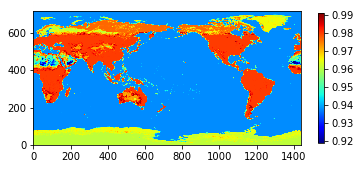

In [71]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from PIL import Image
emiss = Dataset('C:/Users/arkam/Downloads/Reanalysis/surface_emissivity_Fu-Liou_0.5x0.5_53deg.nc','r')
e = emiss['band_emissivity'][0,:,:,4]
e = np.array(Image.fromarray(e).resize((np.shape(sst.sst[0,:,:])[1],np.shape(sst.sst[0,:,:])[0])))
# e = misc.imresize(e,np.shape(sst.sst[0,:,:]))/255.
plt.imshow(e,cmap='jet',origin='lower')
plt.colorbar(shrink=0.6)
plt.show()

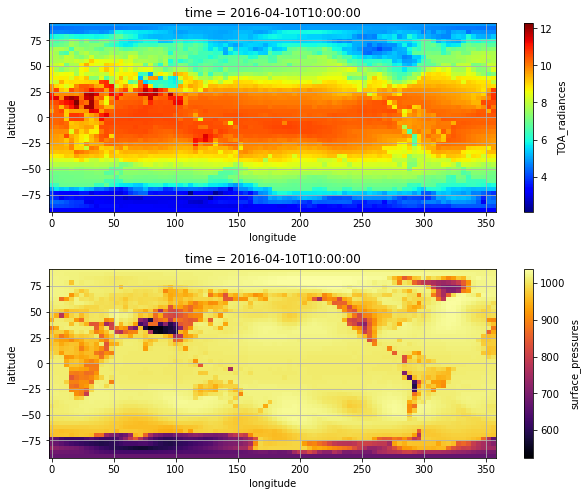

<xarray.Dataset>
Dimensions:            (latitude: 46, longitude: 90, time: 1)
Coordinates:
  * latitude           (latitude) float64 -90.0 -86.0 -82.0 ... 82.0 86.0 90.0
  * longitude          (longitude) float64 0.0 4.0 8.0 ... 348.0 352.0 356.0
  * time               (time) datetime64[ns] 2016-04-10T10:00:00
Data variables:
    TOA_radiances      (time, latitude, longitude) float64 3.293 3.293 ... 4.899
    surface_pressures  (time, latitude, longitude) float64 672.1 ... 1.02e+03

In [75]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.subplot(2,1,1);merged['TOA_radiances'][0,:,:].plot.imshow(cmap='jet');plt.grid()
plt.subplot(2,1,2);merged['surface_pressures'][0,:,:].plot.imshow(cmap='inferno')
plt.grid();plt.subplots_adjust(hspace=0.3);plt.show()
merged

# MODIS WEIGHTING FUNCTIONS & PLANCK RADIATION PROFILES

In [ ]:
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
from PIL import Image
import os
import time
import subprocess
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

#-----------------------------PYTHON 2 SUBPROCESS RUN ALTERNATIVE----------------------------
def run(*popenargs, **kwargs):
    input = kwargs.pop("input", None)
    check = kwargs.pop("handle", False)

    if input is not None:
        if 'stdin' in kwargs:
            raise ValueError('stdin and input arguments may not both be used.')
        kwargs['stdin'] = subprocess.PIPE

    process = subprocess.Popen(*popenargs, **kwargs)
    try:
        stdout, stderr = process.communicate(input)
    except:
        process.kill()
        process.wait()
        raise
    retcode = process.poll()
    if check and retcode:
        raise subprocess.CalledProcessError(
            retcode, process.args, output=stdout, stderr=stderr)
    return retcode, stdout, stderr
#----------------------------------------------------------------------------------------------

#------------------------------------------MODIS Functions-------------------------------------

P_levels = [10,20,30,50,70]
P_levels=np.append(P_levels,np.linspace(100,950,50))
P_levels=np.append(P_levels,np.linspace(900,1025,25))

h = 6.626e-34
c = 299792458
kB = 1.38e-23
def planck(wav, T):
    #Function to calculate Planck radiation for emissivity=1, given wavelength and Temp
    a = 2.0*h*c**2
    b = h*c/(wav*kB*T)
    intensity = a/((wav**5)*(np.exp(b)-1.0))
    return intensity

window_size, poly_order = 29, 3
def dt_dlnP(P,t):
    #Function to calculate normalized wighting functions for a MODIS band, given P and 
    #transmittance profiles
    dtdlnP = np.zeros(len(P))
    for i in range(len(P)-1):
        dtdlnP[i] = -(t[i]-t[i+1])/(np.log(P[i])-np.log(P[i+1]))
    dtdlnP[len(P)-1] = dtdlnP[i] 
    wt_fn = [(dtdlnP[i]-np.min(dtdlnP))/(np.max(dtdlnP)-np.min(dtdlnP))
             for i in range(len(dtdlnP))]
    return wt_fn

#-------------------------------------------------------------------------------------------------

#-------------------------Local Directories and Reanalysis Files----------------------------------

main_directory = 'C:/Users/arkam/Downloads/Reanalysis/'
libradtran_dir = 'C:/Users/arkam/Downloads/libRadtran-2.0.3/'
#these are modified versions with the first commented line removed so that read_fwf works okay.
#there is still a dead first column that is removed when gas_mixing_ratios are turned into a xarray dataset.
afglms = pd.read_fwf(os.path.join(main_directory,'afglms.dat'))
afglmw = pd.read_fwf(os.path.join(main_directory,'afglmw.dat'))
afglsw = pd.read_fwf(os.path.join(main_directory,'afglsw.dat'))
afglss = pd.read_fwf(os.path.join(main_directory,'afglss.dat'))
afglt = pd.read_fwf(os.path.join(main_directory,'afglt.dat'))

def read_reanalysis_files():
    sst = xr.open_dataset(os.path.join(main_directory,'era5_sst_2016.nc'))
    sfp = xr.open_dataset(os.path.join(main_directory,'era5_sfp_2016.nc'))
    temp = xr.open_dataset(os.path.join(main_directory,'era5_temp_2016.nc'))
    shum = xr.open_dataset(os.path.join(main_directory,'era5_shum_2016.nc'))
    geo = xr.open_dataset(os.path.join(main_directory,'era5_geo_2016.nc'))
    data_2mT = xr.open_dataset(os.path.join(main_directory,'era5_2mT_2016.nc')) 
    data_2mD = xr.open_dataset(os.path.join(main_directory,'era5_2mD_2016.nc'))
    emiss = Dataset('C:/Users/arkam/Downloads/Reanalysis/surface_emissivity_Fu-Liou_0.5x0.5_53deg.nc','r')
    
    return sst, sfp, temp, shum, geo, data_2mT, data_2mD,emiss
#-----------------------------------------------------------------------------------------------------------------

#------------------------------------RUN LIBRADTRAN and GAS TRANSMISSION------------------------------------------
def calculate_radiances(i,j, day, band, mu, sstemp, sfpres, temp, shum, geo, data_2mT, data_2mD, emiss, zouts = 'all',
                        afglms=afglms, afglmw=afglmw, afglsw=afglsw, afglss=afglss, afglt=afglt):

    month = sstemp['time.month'][day].data
    column_lat = sstemp.latitude[i]
    column_lon = sstemp.longitude[j]
    e = emiss['band_emissivity'][month-1,:,:,4] #Fu-Liou band between 670-800 cm-1
    e = np.array(Image.fromarray(e).resize((np.shape(sstemp.sst[0,:,:])[1],np.shape(sstemp.sst[0,:,:])[0])))
    albedo = 1-e[i,j]

    #random logic to choose the best reference atmosphere for trace gases. . .
    #probably not the best choice of months blah blah.
    if np.abs(column_lat) < 30.0:
        profile = afglt
    elif ((column_lat >= 30.0) & (month in (4,5,6,7,8,9))) | ((column_lat <= -30.0) & (month in (1,2,3,10,11,12))):
        if np.abs(column_lat) >= 60.0:
            profile = afglss
        else:
            profile = afglms
    else:
        if np.abs(column_lat) >= 60.0:
            profile = afglsw
        else:
            profile = afglmw

    gas_mixing_ratios = np.stack([profile[name].values/profile['air(cm-3)'].values for name in profile.columns[5:]],axis=-1)
    gas_mixing_ratios = xr.Dataset(
        data_vars = {
            'gas_mixing_ratio' : (['pressure', 'gas'], gas_mixing_ratios)
        },
        coords = {
            'pressure': profile['p(mb)'].values,
            'gas': profile.columns[5:]
        }
    )

    #make the vertical coordiatnes of pressure, temperature, height and specific humidity.

    T = temp.t[day,:,i,j].data
    q = shum.q[day,:,i,j].data
    pressures = temp.level.data.astype(np.float32)
    sfp = sfpres.sp[day,i,j].data/100.0
    z_levels = geo.z[day,:,i,j].data/9.8e3

    t2 = data_2mT.t2m[day,i,j]
    d2 = data_2mD.d2m[day,i,j]
    spec_hum_2m = 622.0 *6.113e2 * np.exp(5423.0 * (d2 - 273.15)/(d2 * 273.15))/(1000.0 * sfp)

    #remove all levels that are below surface pressure.
    bad_levels = np.where(pressures > sfp)[0]
    if len(bad_levels) > 0:
        min_index = bad_levels.min()
        z_levels = z_levels[:min_index]
        pressures = pressures[:min_index]
        T = T[:min_index]
        q = q[:min_index]
        
    #hack to avoid duplicated z_levels in atmosphere file due to rounding.
    T1 = T[-1]
    if np.round(z_levels[-1],3) == np.array([0.0]):
        z_levels = z_levels[:-1]
        pressures = pressures[:-1]
        T = T[:-1]
        q = q[:-1]
        
    #add surface level data.
    T = T[np.where(z_levels>0.)]
    q = q[np.where(z_levels>0.)]
    pressures = pressures[np.where(z_levels>0.)]
    z_levels = z_levels[np.where(z_levels>0.)]
    z_levels = np.append(z_levels, np.array([0.0]))
    pressures = np.append(pressures, sfp)
    if not np.isnan(sstemp.sst[day,i,j].data):
        T = np.append(T, sstemp.sst[day,i,j].data)
    else:
        T = np.append(T, t2.data)
    if np.isnan(T[len(T)-1]) or np.abs(T[len(T)-1]-T1)>5.:
        T[len(T)-1] = T1+(z_levels[len(T)-2]*6.5)
    q = np.append(q, spec_hum_2m.data)
   
    # calculate mixing ratios and nearest neighbor fill any missing points.
    # other trace gases not from afgl or specified here are specified from US Standard Atmosphere and 
    #their interpolation is handled by libradtran.
    interped_trace_gases = gas_mixing_ratios.interp(pressure=pressures).bfill(dim='pressure').ffill(dim='pressure')    

    #prepare columns in the atmosphere file.

    #calculate density
    ratio = (pressures * 100.0 / (T * 1.38064852e-23))*1e-6
    h2o = q*ratio
    trace_gases = [gas*ratio for gas in interped_trace_gases.gas_mixing_ratio.data.T]
    trace_gases[2] = h2o #replace afgl h2o with reanalysis h2o.

    columns = [z_levels, pressures, T, ratio]
    columns.extend(trace_gases)
    
    #write atmosphere file.
    with open(os.path.join(libradtran_dir, 'data/atmmod/test.dat'), "w") as f:
        f.write('# This atmosphere file was created by magic and prayer.\n')
        f.write('#     z(km)     p(mb)     T(K)     air(cm-3)     o3(cm-3)     o2(cm-3)     h2o(cm-3)     co2(cm-3)    no2(cm-3)\n')
        for items in zip(*columns):
            f.write('{:10.3f} {:10.5f} {:10.3f} {:7.6E} {:7.6E} {:7.6E} {:7.6E} {:7.6E} {:7.6E}\n'.format(*items))
            #print('{:10.3f} {:10.5f} {:10.3f} {:7.6E} {:7.6E} {:7.6E} {:7.6E} {:7.6E} {:7.6E}\n'.format(*items))

    #prepare inputs specific to the uvspec 'INPUT' file.
    
    #surface wind speed for cox_munk
    #wind_speed = np.sqrt(surface.u10[0,i,j].data**2 + surface.v10[0,i,j].data**2)

    view_mu = mu
    phi = np.array([0.0]) #only one phi angle hard_coded.
    
    if zouts == 'all':
        z_out = z_levels[::-1] #get radiances at all z levels in atmosphere. (reversed to be in ascending order.)
        
    #messy default inputs.
    libradtran_input_string = 'data_files_path ../data/\natmosphere_file ../data/atmmod/test.dat\nrte_solver disort\n'
    libradtran_input_string += '\nsource thermal\noutput_user lambda uu\noutput_process per_nm\n'
    libradtran_input_string += 'no_scattering mol\n'

    #change modis band number here.
    libradtran_input_string += 'mol_abs_param reptran_channel modis_terra_b{}\n'.format(band)

    zout_string = 'zout'
    for z in z_out:
        zout_string += ' {:5.3f}'.format(z)

    mu_string = 'umu'
    for mu in view_mu:
        mu_string += ' {:5.3f}'.format(mu)

    phi_string = 'phi'
    for p in phi:
        phi_string += ' {:5.3f}'.format(p)

    libradtran_input_string += (zout_string + '\n')
    libradtran_input_string += (mu_string + '\n')
    libradtran_input_string += (phi_string + '\n')
    libradtran_input_string += 'albedo {:5.3f}\n'.format(albedo)
#     libradtran_input_string += 'brdf_cam u10 {:5.3f}\n'.format(wind_speed)
    libradtran_input_string += 'verbose\n'

    #write the input string to file, useful for debugging.
#     with open(os.path.join(libradtran_dir, 'examples/test3.INP'), "w") as f:
#         f.write(libradtran_input_string)
    
    #go to libradtran/bin directory so ./uvspec can find stuff.
    get_dir = os.getcwd()
    os.chdir(os.path.join(libradtran_dir, 'bin'))

    input1 = libradtran_input_string.encode('utf-8')
    result, stdout, stderr = run([os.path.join('./uvspec')],input=input1,
                            stdout=subprocess.PIPE,
                            stderr=subprocess.PIPE
                           )

    os.chdir(get_dir) #go back to original directory after running uvspec
    
    #remove old atmosphere file just in case to make sure next uvspec run uses the correct one.
    os.remove(os.path.join(libradtran_dir, 'data/atmmod/test.dat')) 
 
    return stdout, stderr, sfp

def get_gas_properties(stderr):
    """
    TODO
    """
    stderr = stderr.decode('utf-8')
    print(stderr)
    #get number of wavelengths and weight at each wavelength.
    num_wavelengths_identifier = '... calling setup_rte_wlgrid(), generating radiative transfer wavelength grid\n'
    string = stderr[stderr.find(num_wavelengths_identifier)+len(num_wavelengths_identifier):]
    n_wavelengths_substring, buffer = string.split('\n', 1)
    n_wavelengths = np.fromstring(n_wavelengths_substring,sep=' ').astype(np.int)
    
    wavelength_details_string = buffer.split('\n',n_wavelengths[0]+1)[1:n_wavelengths[0]+1]
    wavelength_details = np.zeros([n_wavelengths[0],3])
    for i,line in enumerate(wavelength_details_string):
        split_line = line.split('|')
        for j in range(3):
            wavelength_details[i,j] = np.fromstring(split_line[j],sep=' ')
    
    #get z/pressure level grids that is finally used in RTE
    level_profiles_identifier = '*** Scaling profiles\n'
    data_start = buffer[buffer.find(level_profiles_identifier)+len(level_profiles_identifier):].split('\n',4)[-1]
    level_profile_end_string = '---'
    data = data_start[:data_start.find(level_profile_end_string)].split('\n')
    level_data = np.zeros((len(data)-1, 3))
    for i,line in enumerate(data[:-1]):
        line_data = np.fromstring(line, sep=' ')
        level_data[i,:] = line_data[1], line_data[2], line_data[3]

    #Get the LAYER molecular absorption optical paths.
    layer_tau_wl = np.zeros((n_wavelengths[0], level_data.shape[0]-1))
    for i,wavelength in enumerate(wavelength_details):
        tau_wl_identifier = '*** wavelength: iv = {}, {:10.6f}'.format(i, wavelength[1])
        tau_wl_string_start = buffer[buffer.find('*** wavelength: iv = {}, {:10.6f}'.format(i, wavelength[1])):]
        split_string = tau_wl_string_start.split('\n',7)
        data_start = split_string[-1]
        data = data_start[:data_start.find('---')].split('\n')[:-1]
        for j,line in enumerate(data):
            split_line = line.split('|')
            layer_tau_wl[i,j] = np.fromstring(split_line[3],sep=' ')
    
    #put data in a dataset.
    gas_optical_properties = xr.Dataset(
                            data_vars = {
                                'molecular_absorption_optical_path': (['wavelength', 'layer_bottom_pressure'],
                                                                     layer_tau_wl),
                                'level_height': (['level_pressure'], level_data[:,0]),
                                'level_temperature': (['level_pressure'], level_data[:,2]),
                                'band_weights': ('wavelength', wavelength_details[:,-1]),
                            },
        coords = {
            'wavelength': ('wavelength', wavelength_details[:,1]),
            'level_pressure': ('level_pressure', level_data[:,1]),
            'layer_bottom_pressure': ('layer_bottom_pressure', level_data[1:,1])

        }
    )
    #The band_weights are REPTRAN's radiance weights.
    #To be valid for averaging transmittance the source (Planck function) must be constant across wavelength.
    band_averaged_transmittance = (gas_optical_properties.band_weights * 
                                   np.exp(-gas_optical_properties.molecular_absorption_optical_path)).sum(dim='wavelength')

    gas_optical_properties['band_averaged_transmittance'] = band_averaged_transmittance
    return gas_optical_properties
#-----------------------------------------------------------------------------------------------------------------

#----------------------------MERGE DICTS INTO JOINT XARRAY DATASET------------------------------------------------
def merge_radiance_files(list_of_radiance_outputs):
    wt_list = []
    planck_list = []
    for data in list_of_radiance_outputs:
        new = data.wt_fn
        new2 = xr.DataArray(name= 'planck',data=np.array(data.planck.data),
                                   dims=['time', 'latitude', 'longitude','pressure'],
                                     coords = {
                                         'time': data.time.data,
                                         'latitude': data.latitude.data,
                                         'longitude': data.longitude.data,
                                         'pressure': data.pressure.data
                                     })
        wt_list.append(new)
        planck_list.append(new2)
    new_dataset = xr.Dataset()
    temp = xr.merge(wt_list)
    new_dataset = xr.merge([out for out in list_of_radiance_outputs])
    new_dataset['wt_fn'] = (['time','latitude','longitude','pressure'],xr.merge(wt_list).wt_fn)
    new_dataset['planck'] =(['time','latitude','longitude','pressure'],xr.merge(planck_list).planck)
    new_dataset['wt_fn'].attrs['Description'] = 'MODIS weighting functions at official MODIS P-levels (see ATBD)'
    new_dataset['wt_fn'].attrs['Units'] = 'hPa-1'
    new_dataset['planck'].attrs['Description'] = 'Planck radiance at official MODIS P-levels (see ATBD)'
    new_dataset['planck'].attrs['Units'] = 'W/m2/sr/micron'
    return new_dataset
#-----------------------------------------------------------------------------------------------------------------

time1 = time.time()
band_no = 36
modis = []
sst, sfp, temp, shum, geo, data_2mT, data_2mD, emiss = read_reanalysis_files()
for nday in range(100,101):
#     print('n_day = '+str(nday))
    for i in range(0,721,16):
        print (i)
        for j in range(0,1440,16):
#             print(j)
            stdout, stderr, sf = calculate_radiances(i,j, nday, band_no, np.linspace(1.0,1.0,1), sst, sfp, temp, shum, geo ,data_2mT, data_2mD, emiss)
            tau = get_gas_properties(stderr)
            ftau = interp1d(np.log(tau.layer_bottom_pressure.data[:-1]),tau['band_averaged_transmittance'].data[:-1],fill_value='extrapolate')
            transm = ftau(np.log(P_levels[np.where(P_levels<sf)]))
            transm[transm>1.]=1.
            poly = np.polyfit(P_levels[np.where(P_levels<=sf)],transm,3)
            transm = np.poly1d(poly)(P_levels[np.where(P_levels<sf)])
            surf_T = np.abs(transm[len(transm)-1])
            wt_fn = dt_dlnP(P_levels[np.where(P_levels<=sf)],transm)
            wt_fn = np.append(wt_fn,np.ones(len(P_levels)-len(P_levels[np.where(P_levels<sf)]))*np.nan)
            fT = interp1d(np.log(tau.level_pressure.data[:-1]),tau['level_temperature'].data[:-1],fill_value='extrapolate')
            T = fT(np.log(P_levels))
            BT = planck(13.335*1e-6,T)*1e-6
            data = xr.Dataset(
                data_vars = {'wt_fn': (['time','latitude', 'longitude','pressure'], wt_fn[np.newaxis,np.newaxis,np.newaxis,:]),
                'planck': (['time','latitude','longitude','pressure'], BT[np.newaxis,np.newaxis,np.newaxis,:]),
                'surface_transm': (['time','latitude','longitude'], surf_T[np.newaxis,np.newaxis,np.newaxis])
                        },
                coords = {
                    'time' : np.array([sst.time.data[nday]]),
                    'latitude': np.array([sst.latitude[i]]),
                    'longitude': np.array([sst.longitude[j]]),
                    'pressure': P_levels
                }
            )
            modis.append(data)

merged = merge_radiance_files(modis)
merged.to_netcdf('C:/Users/arkam/Downloads/Reanalysis/ancillary_multi_2016_band36.nc')
print(time.time()-time1)

C:\Users\arkam\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


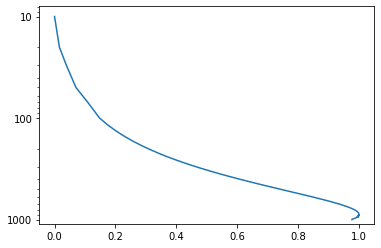

[]


In [7]:
import matplotlib
multi=xr.open_dataset('C:/Users/arkam/Downloads/Reanalysis/ancillary_multi_2016.nc')
wt_fn=multi.wt_fn.data[0,9,0,:]
P_levels=multi.pressure.data
import matplotlib.pyplot as plt
plt.plot(wt_fn,P_levels)
plt.gca().invert_yaxis()
plt.gca().set_yscale('log')
plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylim(1100,0)
plt.show()
# print(P_levels[np.where(wt_fn==np.max(wt_fn))])
multi.close()

# MODIS Multi-level Cloudy Radiance and CO2-Slicing Ratios

In [31]:
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
from PIL import Image
import os
import time
from scipy.interpolate import interp1d

#------------------------------------------MODIS Functions-------------------------------------

P_levels = [10,20,30,50,70]
P_levels=np.append(P_levels,np.linspace(100,950,50))
P_levels=np.append(P_levels,np.linspace(900,1025,25))

window_size, poly_order = 29, 3

def trapezoidal(f, P, n):
    s = 0.0
    h = np.log(P[1])-np.log(P[0])
    s += f[0]/2.0 * h
    for i in range(1, n-1):
        h = np.log(P[i+1])-np.log(P[i])
        s += f[i]*h
    h = np.log(P[n-1])-np.log(P[n-2])
    s += f[n-1]/2.0 * h
    return s

def I_integral(B,wt_fn):
    return B*wt_fn

#-------------------------------------------------------------------------------------------------

#-------------------------Local Directories and Reanalysis Files----------------------------------

main_directory = 'C:/Users/arkam/Downloads/Reanalysis/'
# libradtran_dir = 'C:/Users/arkam/Downloads/libRadtran-2.0.3/'

def read_ancillary_files():
    single33 = xr.open_dataset(os.path.join(main_directory,'ancillary_single_2016_band33.nc'))
    multi33 = xr.open_dataset(os.path.join(main_directory,'ancillary_multi_2016_band33.nc'))
    single35 = xr.open_dataset(os.path.join(main_directory,'ancillary_single_2016_band35.nc'))
    multi35 = xr.open_dataset(os.path.join(main_directory,'ancillary_multi_2016_band35.nc'))
    single36 = xr.open_dataset(os.path.join(main_directory,'ancillary_single_2016_band36.nc'))
    multi36 = xr.open_dataset(os.path.join(main_directory,'ancillary_multi_2016_band36.nc'))
    
    return single33, multi33, single35, multi35, single36, multi36

def generate_ancillary_variables(i,j,day,single1, multi1, single2, multi2, single3, multi3):
    Ics1 = single1.TOA_radiances[day,i,j].data
    Ps1 = single1.surface_pressures[day,i,j].data
    wt1 = multi1.wt_fn[day,i,j,:].data
    B1 = multi1.planck[day,i,j,:].data
    st1 = multi1.surface_transm[day,i,j].data
    Ics2 = single2.TOA_radiances[day,i,j].data
    Ps2 = single2.surface_pressures[day,i,j].data
    wt2 = multi2.wt_fn[day,i,j,:].data
    B2 = multi2.planck[day,i,j,:].data
    st2 = multi2.surface_transm[day,i,j].data
    Ics3 = single3.TOA_radiances[day,i,j].data
    Ps3 = single3.surface_pressures[day,i,j].data
    wt3 = multi3.wt_fn[day,i,j,:].data
    B3 = multi3.planck[day,i,j,:].data
    st3 = multi2.surface_transm[day,i,j].data
    f1 = I_integral(B1,wt1)
    f2 = I_integral(B2,wt2)
    f3 = I_integral(B3,wt3)
    r1=[];r2=[];I1=[];I2=[];I3=[]
    for ilevel in range(0,len(P_levels)):
        n = np.size(P_levels[np.where(np.logical_and(P_levels>P_levels[ilevel],P_levels<=Ps1))])
        Pt = P_levels[np.where(np.logical_and(P_levels>P_levels[ilevel],P_levels<=Ps1))]
        f1t = f1[np.where(np.logical_and(P_levels>P_levels[ilevel],P_levels<=Ps1))]
        f2t = f2[np.where(np.logical_and(P_levels>P_levels[ilevel],P_levels<=Ps1))]
        f3t = f3[np.where(np.logical_and(P_levels>P_levels[ilevel],P_levels<=Ps1))]
        if (len(Pt)>=2):
            r1 = np.append(r1,trapezoidal(f1t, Pt, n)/trapezoidal(f2t, Pt, n))
            r2 = np.append(r2,trapezoidal(f2t, Pt, n)/trapezoidal(f3t, Pt, n))
    r1 = np.append(r1,np.ones(len(P_levels)-len(r1))*np.nan)
    r2 = np.append(r2,np.ones(len(P_levels)-len(r2))*np.nan)
    
    output = xr.Dataset(
                data_vars = {
                    'ratio1': (['time','latitude', 'longitude','pressure'], r1[np.newaxis,np.newaxis,np.newaxis,:]),
                    'ratio2': (['time','latitude','longitude','pressure'], r2[np.newaxis,np.newaxis,np.newaxis,:])
                },
        coords = {
            'time' : np.array([single1.time.data[day]]),
            'latitude': np.array([single1.latitude.data[i]]),
            'longitude': np.array([single1.longitude.data[j]]),
            'pressure': P_levels
        }
    )
    return output

def merge_radiance_files(list_of_radiance_outputs):
    ratio1 = []
    ratio2 = []
    for data in list_of_radiance_outputs:
        new = data.ratio1
        new2 = xr.DataArray(name= 'ratio2',data=np.array(data.ratio2.data),
                                   dims=['time', 'latitude', 'longitude','pressure'],
                                     coords = {
                                         'time': data.time.data,
                                         'latitude': data.latitude.data,
                                         'longitude': data.longitude.data,
                                         'pressure': data.pressure.data
                                     })
        ratio1.append(new)
        ratio2.append(new2)
    new_dataset = xr.Dataset()
    temp = xr.merge(ratio1)
    new_dataset = xr.merge([out for out in list_of_radiance_outputs])
    new_dataset['ratio1'] = (['time','latitude','longitude','pressure'],xr.merge(ratio1).ratio1)
    new_dataset['ratio2'] =(['time','latitude','longitude','pressure'],xr.merge(ratio2).ratio2)
    new_dataset['ratio1'].attrs['Description'] = 'MODIS Radiance Ratio 1 (13.33/13.93 um)'
    new_dataset['ratio1'].attrs['Units'] = 'Unitless'
    new_dataset['ratio2'].attrs['Description'] = 'MODIS Radiance Ratio 1 (13.93/14.23 um)'
    new_dataset['ratio2'].attrs['Units'] = 'Unitless'
    return new_dataset

single33, multi33, single35, multi35, single36, multi36 = read_ancillary_files()
time1 = time.time()
modis = []
for nday in range(single35.surface_pressures.data.shape[0]):
    for i in range(single35.surface_pressures.data.shape[1]):
        print (i)
        for j in range(single35.surface_pressures.data.shape[2]):
            out = generate_ancillary_variables(i, j, 0, single33, multi33, single35, 
                                                          multi35, single36, multi36)
            modis.append(out)
 
merged = merge_radiance_files(modis)
merged.to_netcdf('C:/Users/arkam/Downloads/Reanalysis/ancillary_multi_2016_ratios.nc')
single33.close(); multi33.close(); single35.close(); multi35.close(); single36.close(); multi36.close()
print(time.time()-time1)

0
1
2
3
4
5
6
7
8


C:\Users\arkam\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in double_scalars


9
10


C:\Users\arkam\anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\arkam\anaconda3\lib\site-packages\ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars


11
32.75516724586487


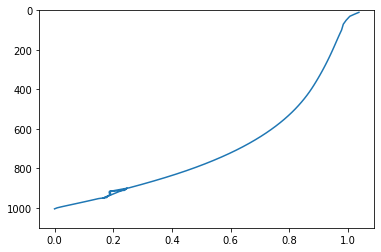

In [7]:
import matplotlib
import matplotlib.pyplot as plt
P_levels=multi35.pressure.data
plt.plot(r1,P_levels)
plt.gca().invert_yaxis()
# plt.gca().set_yscale('log')
plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylim(1100,0)
plt.show()

# Regression Model for CTP and Effective Amount from Reanalysis & Theory

In [58]:
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
from PIL import Image
import os
import time
import subprocess
import scipy
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings("ignore")

#-----------------------------PYTHON 2 SUBPROCESS RUN ALTERNATIVE----------------------------
def run(*popenargs, **kwargs):
    input = kwargs.pop("input", None)
    check = kwargs.pop("handle", False)

    if input is not None:
        if 'stdin' in kwargs:
            raise ValueError('stdin and input arguments may not both be used.')
        kwargs['stdin'] = subprocess.PIPE

    process = subprocess.Popen(*popenargs, **kwargs)
    try:
        stdout, stderr = process.communicate(input)
    except:
        process.kill()
        process.wait()
        raise
    retcode = process.poll()
    if check and retcode:
        raise subprocess.CalledProcessError(
            retcode, process.args, output=stdout, stderr=stderr)
    return retcode, stdout, stderr
#----------------------------------------------------------------------------------------------

#------------------------------------------MODIS Functions-------------------------------------

P_levels = [10,20,30,50,70]
P_levels=np.append(P_levels,np.linspace(100,950,50))
P_levels=np.append(P_levels,np.linspace(900,1025,25))
# P_levels = np.arange(10,1080,5)

h = 6.626e-34
c = 299792458
kB = 1.38e-23
def planck(wav, T):
    #Function to calculate Planck radiation for emissivity=1, given wavelength and Temp
    a = 2.0*h*c**2
    b = h*c/(wav*kB*T)
    intensity = a/((wav**5)*(np.exp(b)-1.0))
    return intensity

window_size, poly_order = 29, 3
def dt_dlnP(P,t):
    #Function to calculate normalized wighting functions for a MODIS band, given P and 
    #transmittance profiles
    dtdlnP = np.zeros(len(P))
    for i in range(len(P)-1):
        dtdlnP[i] = -(t[i]-t[i+1])/(np.log(P[i])-np.log(P[i+1]))
    dtdlnP[len(P)-1] = dtdlnP[i] 
    wt_fn = [(dtdlnP[i]-np.min(dtdlnP))/(np.max(dtdlnP)-np.min(dtdlnP))
             for i in range(len(dtdlnP))]
    return wt_fn

#-------------------------------------------------------------------------------------------------

#-------------------------Local Directories and Reanalysis Files----------------------------------

main_directory = 'C:/Users/arkam/Downloads/Reanalysis/'
libradtran_dir = 'C:/Users/arkam/Downloads/libRadtran-2.0.3/'
#these are modified versions with the first commented line removed so that read_fwf works okay.
#there is still a dead first column that is removed when gas_mixing_ratios are turned into a xarray dataset.
afglms = pd.read_fwf(os.path.join(main_directory,'afglms.dat'))
afglmw = pd.read_fwf(os.path.join(main_directory,'afglmw.dat'))
afglsw = pd.read_fwf(os.path.join(main_directory,'afglsw.dat'))
afglss = pd.read_fwf(os.path.join(main_directory,'afglss.dat'))
afglt = pd.read_fwf(os.path.join(main_directory,'afglt.dat'))

def read_reanalysis_files():
    sst = xr.open_dataset(os.path.join(main_directory,'era5_sst_2016.nc'))
    sfp = xr.open_dataset(os.path.join(main_directory,'era5_sfp_2016.nc'))
    temp = xr.open_dataset(os.path.join(main_directory,'era5_temp_2016.nc'))
    shum = xr.open_dataset(os.path.join(main_directory,'era5_shum_2016.nc'))
    geo = xr.open_dataset(os.path.join(main_directory,'era5_geo_2016.nc'))
    data_2mT = xr.open_dataset(os.path.join(main_directory,'era5_2mT_2016.nc')) 
    data_2mD = xr.open_dataset(os.path.join(main_directory,'era5_2mD_2016.nc'))
    emiss = Dataset('C:/Users/arkam/Downloads/Reanalysis/surface_emissivity_Fu-Liou_0.5x0.5_53deg.nc','r')
    
    return sst, sfp, temp, shum, geo, data_2mT, data_2mD,emiss

# cols=['P','em','P_low','CTP1','CTP2','am1','am2']
cols=['DOY','lat','lon','I1','I2','I3','Ics33','Ics35','Ics36','P','em','P_low','CTP','am','T']
#-----------------------------------------------------------------------------------------------------------------

#------------------------------------RUN LIBRADTRAN and GAS TRANSMISSION------------------------------------------
def func(x, a, c):
    return a*np.exp(-c*x)

def calculate_radiances(i,j, day, band, mu, sstemp, sfpres, temp, shum, geo, data_2mT, data_2mD, emiss, zouts = 'all',
                        afglms=afglms, afglmw=afglmw, afglsw=afglsw, afglss=afglss, afglt=afglt):

    month = sstemp['time.month'][day].data
    column_lat = sstemp.latitude[i]
    column_lon = sstemp.longitude[j]
    e = emiss['band_emissivity'][month-1,:,:,4] #Fu-Liou band between 670-800 cm-1
    e = np.array(Image.fromarray(e).resize((np.shape(sstemp.sst[0,:,:])[1],np.shape(sstemp.sst[0,:,:])[0])))
    albedo = 1-e[i,j]

    #random logic to choose the best reference atmosphere for trace gases. . .
    #probably not the best choice of months blah blah.
    if np.abs(column_lat) < 30.0:
        profile = afglt
    elif ((column_lat >= 30.0) & (month in (4,5,6,7,8,9))) | ((column_lat <= -30.0) & (month in (1,2,3,10,11,12))):
        if np.abs(column_lat) >= 60.0:
            profile = afglss
        else:
            profile = afglms
    else:
        if np.abs(column_lat) >= 60.0:
            profile = afglsw
        else:
            profile = afglmw

    gas_mixing_ratios = np.stack([profile[name].values/profile['air(cm-3)'].values for name in profile.columns[5:]],axis=-1)
    gas_mixing_ratios = xr.Dataset(
        data_vars = {
            'gas_mixing_ratio' : (['pressure', 'gas'], gas_mixing_ratios)
        },
        coords = {
            'pressure': profile['p(mb)'].values,
            'gas': profile.columns[5:]
        }
    )

    #make the vertical coordiatnes of pressure, temperature, height and specific humidity.

    T = temp.t[day,:,i,j].data
    q = shum.q[day,:,i,j].data
    pressures = temp.level.data.astype(np.float32)
    sfp = sfpres.sp[day,i,j].data/100.0
    z_levels = geo.z[day,:,i,j].data/9.8e3

    t2 = data_2mT.t2m[day,i,j]
    d2 = data_2mD.d2m[day,i,j]
    spec_hum_2m = 622.0 *6.113e2 * np.exp(5423.0 * (d2 - 273.15)/(d2 * 273.15))/(1000.0 * sfp)

    #remove all levels that are below surface pressure.
    bad_levels = np.where(pressures > sfp)[0]
    if len(bad_levels) > 0:
        min_index = bad_levels.min()
        z_levels = z_levels[:min_index]
        pressures = pressures[:min_index]
        T = T[:min_index]
        q = q[:min_index]
        
    #hack to avoid duplicated z_levels in atmosphere file due to rounding.
    T1 = T[-1]
    if np.round(z_levels[-1],3) == np.array([0.0]):
        z_levels = z_levels[:-1]
        pressures = pressures[:-1]
        T = T[:-1]
        q = q[:-1]
        
    #add surface level data.
    T = T[np.where(z_levels>0.)]
    q = q[np.where(z_levels>0.)]
    pressures = pressures[np.where(z_levels>0.)]
    z_levels = z_levels[np.where(z_levels>0.)]
    z_levels = np.append(z_levels, np.array([0.0]))
    pressures = np.append(pressures, sfp)
    if not np.isnan(sstemp.sst[day,i,j].data):
        T = np.append(T, sstemp.sst[day,i,j].data)
    else:
        T = np.append(T, t2.data)
    if np.isnan(T[len(T)-1]) or np.abs(T[len(T)-1]-T1)>5.:
        T[len(T)-1] = T1+(z_levels[len(T)-2]*6.5)
    q = np.append(q, spec_hum_2m.data)
   
    # calculate mixing ratios and nearest neighbor fill any missing points.
    # other trace gases not from afgl or specified here are specified from US Standard Atmosphere and 
    #their interpolation is handled by libradtran.
    interped_trace_gases = gas_mixing_ratios.interp(pressure=pressures).bfill(dim='pressure').ffill(dim='pressure')    

    #prepare columns in the atmosphere file.

    #calculate density
    ratio = (pressures * 100.0 / (T * 1.38064852e-23))*1e-6
    h2o = q*ratio
    trace_gases = [gas*ratio for gas in interped_trace_gases.gas_mixing_ratio.data.T]
    trace_gases[2] = h2o #replace afgl h2o with reanalysis h2o.

    columns = [z_levels, pressures, T, ratio]
    columns.extend(trace_gases)
    
    #write atmosphere file.
    with open(os.path.join(libradtran_dir, 'data/atmmod/test.dat'), "w") as f:
        f.write('# This atmosphere file was created by magic and prayer.\n')
        f.write('#     z(km)     p(mb)     T(K)     air(cm-3)     o3(cm-3)     o2(cm-3)     h2o(cm-3)     co2(cm-3)    no2(cm-3)\n')
        for items in zip(*columns):
            f.write('{:10.3f} {:10.5f} {:10.3f} {:7.6E} {:7.6E} {:7.6E} {:7.6E} {:7.6E} {:7.6E}\n'.format(*items))
            #print('{:10.3f} {:10.5f} {:10.3f} {:7.6E} {:7.6E} {:7.6E} {:7.6E} {:7.6E} {:7.6E}\n'.format(*items))

    #prepare inputs specific to the uvspec 'INPUT' file.
    
    #surface wind speed for cox_munk
    #wind_speed = np.sqrt(surface.u10[0,i,j].data**2 + surface.v10[0,i,j].data**2)

    view_mu = mu
    phi = np.array([0.0]) #only one phi angle hard_coded.
    
    if zouts == 'all':
        z_out = z_levels[::-1] #get radiances at all z levels in atmosphere. (reversed to be in ascending order.)
        
    #messy default inputs.
    libradtran_input_string = 'data_files_path ../data/\natmosphere_file ../data/atmmod/test.dat\nrte_solver disort\n'
    libradtran_input_string += '\nsource thermal\noutput_user lambda uu\noutput_process per_nm\n'
    libradtran_input_string += 'no_scattering mol\n'

    #change modis band number here.
    libradtran_input_string += 'mol_abs_param reptran_channel modis_terra_b{}\n'.format(band)

    zout_string = 'zout'
    for z in z_out:
        zout_string += ' {:5.3f}'.format(z)

    mu_string = 'umu'
    for mu in view_mu:
        mu_string += ' {:5.3f}'.format(mu)

    phi_string = 'phi'
    for p in phi:
        phi_string += ' {:5.3f}'.format(p)

    libradtran_input_string += (zout_string + '\n')
    libradtran_input_string += (mu_string + '\n')
    libradtran_input_string += (phi_string + '\n')
    libradtran_input_string += 'albedo {:5.3f}\n'.format(albedo)
#     libradtran_input_string += 'brdf_cam u10 {:5.3f}\n'.format(wind_speed)
    libradtran_input_string += 'verbose\n'

    #write the input string to file, useful for debugging.
#     with open(os.path.join(libradtran_dir, 'examples/test3.INP'), "w") as f:
#         f.write(libradtran_input_string)
    
    #go to libradtran/bin directory so ./uvspec can find stuff.
    get_dir = os.getcwd()
    os.chdir(os.path.join(libradtran_dir, 'bin'))

    input1 = libradtran_input_string.encode('utf-8')
    result, stdout, stderr = run([os.path.join('./uvspec')],input=input1,
                            stdout=subprocess.PIPE,
                            stderr=subprocess.PIPE
                           )

    os.chdir(get_dir) #go back to original directory after running uvspec
    
    #remove old atmosphere file just in case to make sure next uvspec run uses the correct one.
    os.remove(os.path.join(libradtran_dir, 'data/atmmod/test.dat')) 
 
    return stdout, stderr, sfp, h2o, T, pressures

def get_gas_properties(stderr):
    """
    TODO
    """
    stderr = stderr.decode('utf-8')
    #get number of wavelengths and weight at each wavelength.
    num_wavelengths_identifier = '... calling setup_rte_wlgrid(), generating radiative transfer wavelength grid\n'
    string = stderr[stderr.find(num_wavelengths_identifier)+len(num_wavelengths_identifier):]
    n_wavelengths_substring, buffer = string.split('\n', 1)
    n_wavelengths = np.fromstring(n_wavelengths_substring,sep=' ').astype(np.int)
    
    wavelength_details_string = buffer.split('\n',n_wavelengths[0]+1)[1:n_wavelengths[0]+1]
    wavelength_details = np.zeros([n_wavelengths[0],3])
    for i,line in enumerate(wavelength_details_string):
        split_line = line.split('|')
        for j in range(3):
            wavelength_details[i,j] = np.fromstring(split_line[j],sep=' ')
    
    #get z/pressure level grids that is finally used in RTE
    level_profiles_identifier = '*** Scaling profiles\n'
    data_start = buffer[buffer.find(level_profiles_identifier)+len(level_profiles_identifier):].split('\n',4)[-1]
    level_profile_end_string = '---'
    data = data_start[:data_start.find(level_profile_end_string)].split('\n')
    level_data = np.zeros((len(data)-1, 3))
    for i,line in enumerate(data[:-1]):
        line_data = np.fromstring(line, sep=' ')
        level_data[i,:] = line_data[1], line_data[2], line_data[3]

    #Get the LAYER molecular absorption optical paths.
    layer_tau_wl = np.zeros((n_wavelengths[0], level_data.shape[0]-1))
    for i,wavelength in enumerate(wavelength_details):
        tau_wl_identifier = '*** wavelength: iv = {}, {:10.6f}'.format(i, wavelength[1])
        tau_wl_string_start = buffer[buffer.find('*** wavelength: iv = {}, {:10.6f}'.format(i, wavelength[1])):]
        split_string = tau_wl_string_start.split('\n',7)
        data_start = split_string[-1]
        data = data_start[:data_start.find('---')].split('\n')[:-1]
        for j,line in enumerate(data):
            split_line = line.split('|')
            layer_tau_wl[i,j] = np.fromstring(split_line[3],sep=' ')
    
    #put data in a dataset.
    gas_optical_properties = xr.Dataset(
                            data_vars = {
                                'molecular_absorption_optical_path': (['wavelength', 'layer_bottom_pressure'],
                                                                     layer_tau_wl),
                                'level_height': (['level_pressure'], level_data[:,0]),
                                'level_temperature': (['level_pressure'], level_data[:,2]),
                                'band_weights': ('wavelength', wavelength_details[:,-1]),
                            },
        coords = {
            'wavelength': ('wavelength', wavelength_details[:,1]),
            'level_pressure': ('level_pressure', level_data[:,1]),
            'layer_bottom_pressure': ('layer_bottom_pressure', level_data[1:,1])

        }
    )
    #The band_weights are REPTRAN's radiance weights.
    #To be valid for averaging transmittance the source (Planck function) must be constant across wavelength.
    band_averaged_transmittance = (gas_optical_properties.band_weights * 
                                   np.exp(-gas_optical_properties.molecular_absorption_optical_path)).sum(dim='wavelength')

    gas_optical_properties['band_averaged_transmittance'] = band_averaged_transmittance
    return gas_optical_properties

def trapezoidal(f, P, n):
    s = 0.0
    h = np.log(P[1])-np.log(P[0])
    s += f[0]/2.0 * h
    for i in range(1, n-1):
        h = np.log(P[i+1])-np.log(P[i])
        s += f[i]*h
    h = np.log(P[n-1])-np.log(P[n-2])
    s += f[n-1]/2.0 * h
    return s

def I_integral(B,wt_fn):
    return B*wt_fn

def CTP(P_levels, diff):
    asign = np.sign(diff)
    signchange = (np.abs((np.roll(asign, 1) - asign)) != 0).astype(int)
    signchange[0] = 0
    return (P_levels[np.where(signchange==1)])

def co2_slicing_vars(transm,B,wt,P_levels,Ps,Ts):
    f = I_integral(B,wt)
    I=[];Ics=[]
    strans = transm[np.max(np.where(P_levels<Ps))]
    for ilevel in range(len(P_levels)):
        n = np.size(P_levels[np.where(np.logical_and(P_levels>P_levels[ilevel],P_levels<Ps))])
        Pt = P_levels[np.where(np.logical_and(P_levels>P_levels[ilevel],P_levels<Ps))]
        if (len(Pt)>=2):
            I = np.append(I, B[ilevel]*transm[ilevel] + trapezoidal(f, Pt, n))
    I = np.append(I, np.ones(len(P_levels)-len(I))*np.nan)
    n = np.size(P_levels[np.where(np.logical_and(P_levels>P_levels[0],P_levels<Ps))])
    Pt = P_levels[np.where(np.logical_and(P_levels>P_levels[0],P_levels<Ps))]
    Ics = strans * B[len(B)-1] + trapezoidal(f, Pt, n)
    
    return I, Ics

time1 = time.time()
band_no = [33, 35, 36]
wav = [13.335*1e-6,13.935*1e-6,14.235*1e-6]
level = [8,11,14,17,19,22,25,29,31,33]
eff_am = [0.1, 0.2, 0.3, 0.5, 0.6, 0.8, 0.9]
lst = []
for nday in range(0,30,30): 
    print('day = ', str(nday))
    for i in range(0,721,64):
        print(i)
        for j in range(0,1440,64):
            for nband in range(0,3):
                sst, sfp, temp, shum, geo, data_2mT, data_2mD,emiss = read_reanalysis_files()
                stdout, stderr, sfp, h2o, T, P = calculate_radiances(i, j, 0, band_no[nband], np.linspace(1.0,1.0,1), sst,
                                                                  sfp, temp, shum, geo ,data_2mT, data_2mD, emiss)

                Ps=sfp;Ts=T[len(T)-1]; T650=T[5];T500=T[4];T250=T[2];T50=T[0]
                try:
                    popt, pcov = scipy.optimize.curve_fit(func, P, h2o, p0=(h2o[len(h2o)-1], 1e-6), maxfev=1000);h2os = h2o[len(h2o)-1]
                except:
                    popt=poptt; pcov=pcovt
                poptt=popt;pcovt=pcov
                tau = get_gas_properties(stderr)
                ftau = interp1d(np.log(tau.layer_bottom_pressure.data[:-1]),tau['band_averaged_transmittance'].data[:-1],fill_value='extrapolate')
                transm = ftau(np.log(P_levels[np.where(P_levels<sfp)]))
                transm[transm>1.]=1.
                poly = np.polyfit(P_levels[np.where(P_levels<=sfp)],transm,3)
                transm = np.poly1d(poly)(P_levels[np.where(P_levels<sfp)])
                surf_T = np.abs(transm[len(transm)-1])
                wt_fn = dt_dlnP(P_levels[np.where(P_levels<=sfp)],transm)
                transm = np.append(transm,np.ones(len(P_levels)-len(transm))*np.nan)
                wt_fn = np.append(wt_fn,np.ones(len(P_levels)-len(P_levels[np.where(P_levels<sfp)]))*np.nan)
                fT = interp1d(np.log(tau.level_pressure.data[:-1]),tau['level_temperature'].data[:-1],fill_value='extrapolate')
                T = fT(np.log(P_levels))
                BT = planck(wav[nband],T)*1e-6
                if nband == 0: 
                    f1 = I_integral(BT,wt_fn)
                    I33, Ics33 = co2_slicing_vars(transm, BT, wt_fn, P_levels, sfp, Ts)
                if nband == 1:
                    f2 = I_integral(BT,wt_fn)
                    I35, Ics35 = co2_slicing_vars(transm, BT, wt_fn, P_levels, sfp, Ts)
                if nband == 2: 
                    f3 = I_integral(BT,wt_fn)
                    I36, Ics36 = co2_slicing_vars(transm, BT, wt_fn, P_levels, sfp, Ts)

            ratio1 = (I33-Ics33)/(I35-Ics35)
            ratio2 = (I35-Ics35)/(I36-Ics36)
#             noise1 = np.random.normal(0, 0.25, (10,5,5))
#             noise2 = np.random.normal(0, 0.25, (10,5,5))
#             noise3 = np.random.normal(0, 0.25, (10,5,5))
            P_high = 150 + np.random.rand(10)*(600-150)
            for ilevel in range(len(level)):
                hlevel = np.where(np.abs(P_levels-P_high[ilevel])==np.min(np.abs(P_levels-P_high[ilevel])))
                P_low = P_high[ilevel] + 75 + np.random.rand(10)*(sfp-50. - P_high[ilevel]-75.)
                eff_am = np.random.rand(10)
                for nAm in range(len(eff_am)):
                    for lcld in range(len(P_low)):
                        llevel = np.where(np.abs(P_levels-P_low[lcld])==np.min(np.abs(P_levels-P_low[lcld])))
                        n = np.size(P_levels[np.where(np.logical_and(P_levels>P_levels[hlevel],
                                                                     P_levels<P_levels[llevel]))])
                        Pt = P_levels[np.where(np.logical_and(P_levels>P_levels[hlevel],
                                                                     P_levels<P_levels[llevel]))]
                        try:
                            I1 = Ics33 + eff_am[nAm] * (I33[hlevel] - Ics33) - (1-eff_am[nAm])*trapezoidal(f1,Pt,n) #+ noise1[ilevel,nAm,lcld]
                            I2 = Ics35 + eff_am[nAm] * (I35[hlevel] - Ics35) - (1-eff_am[nAm])*trapezoidal(f2,Pt,n) #+ noise2[ilevel,nAm,lcld]
                            I3 = Ics36 + eff_am[nAm] * (I36[hlevel] - Ics36) - (1-eff_am[nAm])*trapezoidal(f3,Pt,n) #+ noise3[ilevel,nAm,lcld]
    #                         if ((Ics33-I1)>0.75 and (Ics35-I2)>1.):
                            try:
                                r1 = (Ics33-I1)/(Ics35-I2)
                                diff1 = (ratio1-r1); CTP1=CTP(P_levels,diff1)[np.min(np.where(np.logical_and(CTP(P_levels,diff1)>100.,
                                                                                                         CTP(P_levels,diff1)<650.)))]
                                e1 = (I1 - Ics33)/(I33[np.where(P_levels==CTP1)] - Ics33)
                                e2 = (I2 - Ics35)/(I35[np.where(P_levels==CTP1)] - Ics35)
                                amount1 = (e1+e2)/2.
                                if (amount1>1. or amount1<=0.):
                                    amount1 = np.nan
                            except:
                                CTP1 = np.nan; amount1=np.nan
    #                         else:
    #                             CTP1 = np.nan
    #                             amount1 = np.nan
    #                         if ((Ics35-I2)>1. and (Ics36-I3)>1.25):
                            try:
                                    r2 = (Ics35-I2)/(Ics36-I3)
                                    diff2 = (ratio2-r2); CTP2=CTP(P_levels,diff2)[np.min(np.where(np.logical_and(CTP(P_levels,diff2)>100.,
                                                                                                             CTP(P_levels,diff2)<650.)))]
                                    e1 = (I2 - Ics35)/(I35[np.where(P_levels==CTP2)] - Ics35)
                                    e2 = (I3 - Ics36)/(I36[np.where(P_levels==CTP2)] - Ics36)
                                    amount2 = (e1+e2)/2.
                                    if (amount2>1. or amount2<=0.):
                                        amount2 = np.nan
                            except:
                                    CTP2 = np.nan; amount2=np.nan
#                             print(CTP1,CTP2,amount1,amount2)
                            ############################
                            #when the two bands are not calculated separately
                            if(np.isnan([CTP1])==True and np.isnan([CTP2])==True):
                                CP = np.nan
                                am = np.nan
                            elif(np.isnan([CTP1])==False or np.isnan([CTP2])==False):
                                if(np.nanmean([CTP1,CTP2])>250.):
                                    CP = CTP1
                                    am = float(amount1)
                                else:
                                    CP = CTP2
                                    am = float(amount2)
#                             print([P_high[ilevel],eff_am[nAm],P_low[lcld],CP, am])
                            lst.append([nday,i,j,I1[0],I2[0],I3[0],Ics33,Ics35,Ics36,P_high[ilevel],eff_am[nAm],
                                        P_low[lcld],CP,am,fT(np.log(P_high[ilevel]))])
                            ###########################
#                             lst.append([P_high[ilevel],eff_am[nAm],P_low[lcld],
#                                         CTP1, CTP2, float(amount1), float(amount2)])
                        except:
                            continue

                        
# time1 = time.time()
# modis = []
# for nday in range(single35.surface_pressures.data.shape[0]):
#     for i in range(single35.surface_pressures.data.shape[1]):
#         print (i)
#         for j in range(single35.surface_pressures.data.shape[2]):
#             stdout, stderr, sfp, h20, T = generate_ancillary_variables(i, j, 0, single33, multi33, single35, 
#                                                           multi35, single36, multi36)
#             modis.append(out)

# import matplotlib
# import matplotlib.pyplot as plt
# plt.plot(I, P_levels)
# plt.gca().invert_yaxis()
# ax2 = plt.gca().twiny()
# ax2.plot(T, P_levels, 'r')
# # plt.gca().set_yscale('log')
# plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# plt.ylim(1100,0)
# plt.show()
df = pd.DataFrame(lst, columns=cols)
print(time.time()-time1)
df.to_csv('C:/Users/arkam/Downloads/Reanalysis/slicing_database_2016_12UTC_3.csv')
df

day =  0
0
64
128
192
256
320
384
448
512
576
640
704
794.5794534683228


,DOY,lat,lon,I1,I2,I3,Ics33,Ics35,Ics36,P,em,P_low,CTP,am,T
0,0,0,0,2.621703,2.256835,1.972227,4.219996,3.020325,2.487978,396.522043,0.900720,594.834773,394.897959,0.902148,225.60728529889772
1,0,0,0,2.618866,2.254536,1.968869,4.219996,3.020325,2.487978,396.522043,0.900720,762.336481,394.897959,0.904307,225.60728529889772
2,0,0,0,2.619911,2.255310,1.969956,4.219996,3.020325,2.487978,396.522043,0.900720,699.371684,394.897959,0.903554,225.60728529889772
3,0,0,0,2.622248,2.257346,1.972999,4.219996,3.020325,2.487978,396.522043,0.900720,572.656153,394.897959,0.901692,225.60728529889772
4,0,0,0,2.623133,2.258217,1.974315,4.219996,3.020325,2.487978,396.522043,0.900720,500.013571,394.897959,0.900927,225.60728529889772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275575,0,704,1408,2.314070,1.973571,1.686087,2.189832,1.836489,1.564869,447.249679,0.314302,646.423902,429.591837,0.287958,230.08505685941725
275576,0,704,1408,2.316136,1.975287,1.687777,2.189832,1.836489,1.564869,447.249679,0.314302,613.982320,429.591837,0.292146,230.08505685941725
275577,0,704,1408,2.318628,1.977358,1.689771,2.189832,1.836489,1.564869,447.249679,0.314302,599.272708,429.591837,0.297201,230.08505685941725
275578,0,704,1408,2.316136,1.975287,1.687777,2.189832,1.836489,1.564869,447.249679,0.314302,612.233126,429.591837,0.292146,230.08505685941725


In [15]:
import os
import warnings
import numpy as np
import xarray as xr
import pandas as pd
from scipy.interpolate import interp1d
warnings.filterwarnings("ignore")
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 

h = 6.626e-34
c = 299792458
kB = 1.38e-23
main_directory = 'C:/Users/arkam/Downloads/Reanalysis/'
temp = xr.open_dataset(os.path.join(main_directory,'era5_temp_2016.nc'))
df = pd.read_csv('C:/Users/arkam/Downloads/Reanalysis/slicing_database_2016_12UTC_3.csv', index_col=0)
# df = df.drop(columns=df.columns[0])
df1 = df.dropna(axis=0,how='any')
# df1 = df1.iloc[np.where(np.logical_and(df1['am']>0.,df1['am']<=1.))]

def polyfit(X,Y,deg,var):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 0)
    poly = PolynomialFeatures(degree = deg) 
    X_poly = poly.fit_transform(X_train) 
    X_test_poly = poly.fit_transform(X_test) 
    poly.fit(X_train, Y_train) 
    model2 = linear_model.LinearRegression() 
    model2.fit(X_poly, Y_train)
    y_pred2 = model2.predict(X_test_poly)

    # Root Mean Squared Deviation and R^2 value
    rmsd = np.sqrt(mean_squared_error(Y_test, y_pred2))      
    r2_value = r2_score(Y_test, y_pred2)  

    print("Regression Model for ",var)
    print("Root Mean Square Error \n", rmsd)
    print("R^2 Value: \n", r2_value)
    
    return Y_test,y_pred2,poly.powers_,model2.coef_

def write_model_coef(var,p,c):
    file = open('C:/Users/arkam/Downloads/Reanalysis/'+var+'.txt','w')
    for i in range(len(c)):
        if (p.shape[1]==4):
            file.write(str(p[i,0])+' '+str(p[i,1])+' '+
                      str(p[i,2])+' '+str(p[i,3])+' '+
                      str('%.5f' % c[i])+'\n')
        else:
            file.write(str(p[i,0])+' '+str(p[i,1])+' '+
                      str(p[i,2])+' '+
                      str('%.5f' % c[i])+'\n')
    file.close() 

X = df1.drop(columns=['DOY','lat','lon','Ics33','Ics35','Ics36','I1','I2','I3','P','em','T'])
Y = df1['em']
y1,y2,p1,c1 = polyfit(X,Y,2,'Emissivity')

amount = np.zeros(df1.shape[0])
for j in range(df1.shape[0]):
    for i in range(p1.shape[0]):
        amount[j] = amount[j] + (df1['P_low'].values[j]**p1[i,0]*df1['CTP'].values[j]**p1[i,1]*df1['am'].values[j]**p1[i,2])*c1[i]
df1['amount']=amount+0.085
df1 = df1.drop(df1[(df1.amount <= 0.)].index)
df1 = df1.drop(df1[(df1.amount > 1.)].index)
df1['Tc'] = ((h*c/(kB*13.34*1e-6))/(np.log(1+((2*h*c**2*df1['amount'])/((13.34*1e-6)**5*(df1['I1']+(df1['amount']-1)*df1['Ics33'])*1e6))))+
             (h*c/(kB*13.94*1e-6))/(np.log(1+((2*h*c**2*df1['amount'])/((13.94*1e-6)**5*(df1['I2']+(df1['amount']-1)*df1['Ics35'])*1e6))))+
             (h*c/(kB*14.24*1e-6))/(np.log(1+((2*h*c**2*df1['amount'])/((14.24*1e-6)**5*(df1['I3']+(df1['amount']-1)*df1['Ics36'])*1e6)))))/3.
P = temp.level.data.astype(np.float32);Pc=[]
for j in range(df1.shape[0]):
    T = temp.t[df1['DOY'].values[j],:,df1['lat'].values[j],df1['lon'].values[j]].values
    fP = interp1d(T, np.log(P),fill_value='extrapolate')
    Pc = np.append(Pc, np.exp(fP(df1['Tc'].values[j])))
df1['Pc'] = Pc
df1

Regression Model for  Emissivity
Root Mean Square Error 
 0.08362769316414823
R^2 Value: 
 0.9020743756112077


,DOY,lat,lon,I1,I2,I3,Ics33,Ics35,Ics36,P,em,P_low,CTP,am,T,amount,Tc,Pc
0,0,0,0,2.621703,2.256835,1.972227,4.219996,3.020325,2.487978,396.522043,0.900720,594.834773,394.897959,0.902148,225.607285,0.904451,221.733582,358.247096
1,0,0,0,2.618866,2.254536,1.968869,4.219996,3.020325,2.487978,396.522043,0.900720,762.336481,394.897959,0.904307,225.607285,0.889337,221.288644,354.093520
2,0,0,0,2.619911,2.255310,1.969956,4.219996,3.020325,2.487978,396.522043,0.900720,699.371684,394.897959,0.903554,225.607285,0.896659,221.496466,356.027551
3,0,0,0,2.622248,2.257346,1.972999,4.219996,3.020325,2.487978,396.522043,0.900720,572.656153,394.897959,0.901692,225.607285,0.905267,221.768180,358.572104
4,0,0,0,2.623133,2.258217,1.974315,4.219996,3.020325,2.487978,396.522043,0.900720,500.013571,394.897959,0.900927,225.607285,0.907041,221.835894,359.209064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275575,0,704,1408,2.314070,1.973571,1.686087,2.189832,1.836489,1.564869,447.249679,0.314302,646.423902,429.591837,0.287958,230.085057,0.288930,224.270917,341.688293
275576,0,704,1408,2.316136,1.975287,1.687777,2.189832,1.836489,1.564869,447.249679,0.314302,613.982320,429.591837,0.292146,230.085057,0.293968,224.241525,340.512793
275577,0,704,1408,2.318628,1.977358,1.689771,2.189832,1.836489,1.564869,447.249679,0.314302,599.272708,429.591837,0.297201,230.085057,0.299139,224.234117,340.217137
275578,0,704,1408,2.316136,1.975287,1.687777,2.189832,1.836489,1.564869,447.249679,0.314302,612.233126,429.591837,0.292146,230.085057,0.294010,224.240232,340.461163


In [14]:
df1['Tc'].values[j]

234.08123942871472

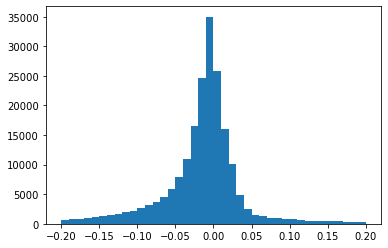

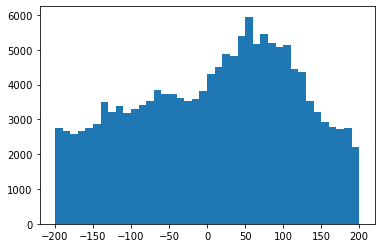

In [17]:
import matplotlib.pyplot as plt
plt.hist(df1['em'].values-df1['amount'].values, bins=40, range=(-.2,.2));plt.show()
plt.hist(df1['P'].values-df1['Pc'].values, bins=40, range=(-200,200));plt.show()

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 

df = pd.read_csv('C:/Users/arkam/Downloads/Reanalysis/slicing_database_2016_12UTC.csv', index_col=0)
# df = df.drop(columns=df.columns[0])
df1 = df.dropna(axis=0,how='any')
# df1 = df1.loc[abs(df1['P']-df1['CTP1'])>50.]

def polyfit(X,Y,deg,var):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 0)
    poly = PolynomialFeatures(degree = deg) 
    X_poly = poly.fit_transform(X_train) 
    X_test_poly = poly.fit_transform(X_test) 
    poly.fit(X_train, Y_train) 
    model2 = linear_model.LinearRegression() 
    model2.fit(X_poly, Y_train)
    y_pred2 = model2.predict(X_test_poly)

    # Root Mean Squared Deviation and R^2 value
    rmsd = np.sqrt(mean_squared_error(Y_test, y_pred2))      
    r2_value = r2_score(Y_test, y_pred2)  

    print("Regression Model for ",var)
    print("Root Mean Square Error \n", rmsd)
    print("R^2 Value: \n", r2_value)
    
    return Y_test,y_pred2,poly.powers_,model2.coef_

def write_model_coef(var,p,c):
    file = open('C:/Users/arkam/Downloads/Reanalysis/'+var+'.txt','w')
    for i in range(len(c)):
        if (p.shape[1]==4):
            file.write(str(p[i,0])+' '+str(p[i,1])+' '+
                      str(p[i,2])+' '+str(p[i,3])+' '+
                      str('%.5f' % c[i])+'\n')
        else:
            file.write(str(p[i,0])+' '+str(p[i,1])+' '+
                      str(p[i,2])+' '+
                      str('%.5f' % c[i])+'\n')
    file.close() 

X = df1.drop(columns=['P','em'])
Y = df1['em']
y1,y2,p1,c1 = polyfit(X,Y,2,'Emissivity')

amount = np.zeros(df1.shape[0])
for j in range(df1.shape[0]):
    for i in range(p1.shape[0]):
        amount[j] = amount[j] + (df1['P_low'].values[j]**p1[i,0]*df1['CTP1'].values[j]**p1[i,1]*df1['am1'].values[j]**p1[i,2])*c1[i] 
df1['amount']=amount
df1 = df1.drop(df1[(df1.amount <= 0.)].index)
df1 = df1.drop(df1[(df1.amount > 1.)].index)

X = df1.drop(columns=['P','em','CTP2','am2']); 
Y = df1['P']
y11,y22,p2,c2 = polyfit(X,Y,2,'CTP1_Error')
X = df1.drop(columns=['P','em','CTP1','am1'])
Y = df1['P']
y111,y222,p3,c3 = polyfit(X,Y,2,'CTP2_Error')
write_model_coef('Emissivity',p1,c1)
write_model_coef('CTP1',p2,c2)
write_model_coef('CTP2',p3,c3)

Regression Model for  Emissivity
Root Mean Square Error 
 0.06473136660039128
R^2 Value: 
 0.9346115082667993
Regression Model for  CTP1_Error
Root Mean Square Error 
 79.72462306133446
R^2 Value: 
 0.6268152452405751
Regression Model for  CTP2_Error
Root Mean Square Error 
 69.31037902762864
R^2 Value: 
 0.7179439028312453


In [2]:
X

,P_low,CTP2,am2,amount
2,538.256218,256.122449,0.420592,0.768435
3,529.755301,256.122449,0.420592,0.770882
5,489.250480,238.775510,0.416420,0.781820
7,545.763251,256.122449,0.421762,0.766231
12,538.256218,256.122449,0.431487,0.768438
...,...,...,...,...
3306937,541.309950,221.428571,0.726551,0.856648
3306938,566.109379,221.428571,0.726113,0.852770
3306939,499.292199,221.428571,0.727716,0.862202
3306950,382.084585,238.775510,0.551703,0.870915


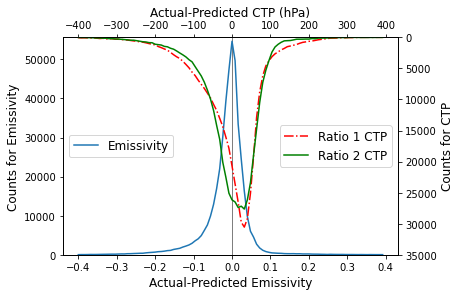

(array([0.]),
 3.2217602923901675e-05,
 0.06473135858284076,
 array([32.]),
 0.20561668653783277,
 79.72435790929994,
 array([32.]),
 0.08686358055597469,
 69.31032459649796)

In [5]:
import matplotlib.pyplot as plt
counts1, edges1 = np.histogram(y1-y2-0.01, bins=100, range=(-0.4,0.4))
counts2, edges2 = np.histogram(y11-y22, bins=100, range=(-400,400.))
counts3, edges3 = np.histogram(y111-y222, bins=100, range=(-400,400.))
y=np.linspace(-100,np.max(counts1)+1000)
x=np.zeros(len(y))
# plt.hist(Y_test-y_pred2, bins=80, range=(-0.4,0.4), linewidth=1.2, edgecolor='k')
ax=plt.gca()
ax.plot(x,y,'k',linestyle='-',linewidth=0.5)
ax.plot(edges1[:-1],counts1,label="Emissivity")
ax.set_xlabel('Actual-Predicted Emissivity', fontsize=12)
ax.set_ylabel('Counts for Emissivity', fontsize=12)
ax2, ax3 = plt.twinx(), plt.twiny()
ax3.plot(edges2[:-1],counts2,'r',linestyle='-.',label='Ratio 1 CTP')
ax3.plot(edges3[:-1],counts3,'g',linestyle='-',label='Ratio 2 CTP')
ax3.set_xlabel('Actual-Predicted CTP (hPa)', fontsize=12)
ax2.set_ylabel('Counts for CTP', fontsize=12)
ax.set_ylim(0,np.max(counts1)+1000)
ax2.set_ylim(0,35000)
ax2.invert_yaxis()
ax.legend(fontsize=12, loc='center left')
ax3.legend(fontsize=12, loc='center right')
plt.show()
edges1[np.where(counts1==np.max(counts1))], np.mean(y1-y2), np.std(y1-y2), edges2[np.where(counts2==np.max(counts2))], np.mean(y11-y22), np.std(y11-y22), \
edges3[np.where(counts3==np.max(counts3))], np.mean(y111-y222), np.std(y111-y222)

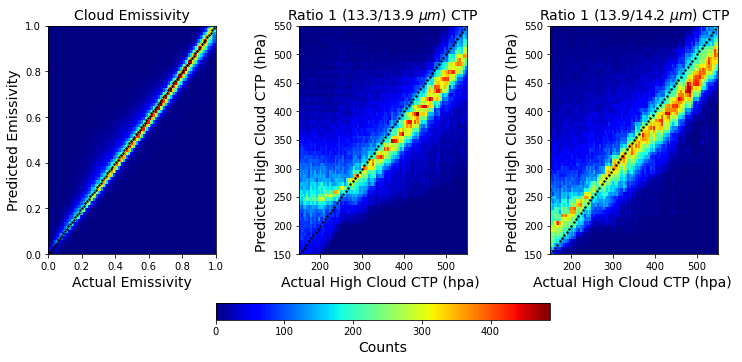

In [224]:
import matplotlib
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
ax = axes.flat[0]
x=np.linspace(0,1,100)
im = ax.hist2d(y1,y2,cmap='jet',bins=100)
ax.set_xlim(0,1);ax.set_ylim(0,1)
ax.set_xlabel('Actual Emissivity', fontsize=14)
ax.set_ylabel('Predicted Emissivity', fontsize=14)
ax.set_title('Cloud Emissivity', fontsize=14)
ax.scatter(x,x,s=8,color='k',marker='.')
ax = axes.flat[1]
im = ax.hist2d(y11,y22,cmap='jet',bins=100)
ax.set_xlim(150.,550.);ax.set_ylim(150.,550.)
x=np.linspace(0,550,100)
ax.scatter(x,x,color='k',s=8,marker='.')
ax.set_xlabel(r'Actual High Cloud CTP (hpa) ', fontsize=14)
ax.set_ylabel(r'Predicted High Cloud CTP (hPa) ', fontsize=14)
ax.set_title('Ratio 1 (13.3/13.9 $\mu m$) CTP', fontsize=14)
ax = axes.flat[2]
im = plt.hist2d(y111,y222,cmap='jet',bins=100)
ax.set_xlim(150.,550.)
ax.set_ylim(150.,550.)
ax.set_xlabel('Actual High Cloud CTP (hpa) ', fontsize=14)
ax.set_ylabel('Predicted High Cloud CTP (hPa) ', fontsize=14)
ax.set_title('Ratio 1 (13.9/14.2 $\mu m$) CTP', fontsize=14)
ax.scatter(x,x,color='k',s=8,marker='.')
fig.subplots_adjust(wspace=0.5)
cb = plt.colorbar(ax=axes.flat[:], orientation='horizontal', shrink=0.5) 
cb.set_label('Counts', fontsize=14)
plt.show()

In [25]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 

df = pd.read_csv('C:/Users/arkam/Downloads/Reanalysis/slicing_database_2016_12UTC_2.csv', index_col=0)
# df = df.drop(columns=df.columns[0])
df1 = df.dropna(axis=0,how='any')
# df1 = df1.loc[abs(df1['P']-df1['CTP1'])>50.]

def polyfit(X,Y,deg,var):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 0)
    poly = PolynomialFeatures(degree = deg) 
    X_poly = poly.fit_transform(X_train) 
    X_test_poly = poly.fit_transform(X_test) 
    poly.fit(X_train, Y_train) 
    model2 = linear_model.LinearRegression() 
    model2.fit(X_poly, Y_train)
    y_pred2 = model2.predict(X_test_poly)

    # Root Mean Squared Deviation and R^2 value
    rmsd = np.sqrt(mean_squared_error(Y_test, y_pred2))      
    r2_value = r2_score(Y_test, y_pred2)  

    print("Regression Model for ",var)
    print("Root Mean Square Error \n", rmsd)
    print("R^2 Value: \n", r2_value)
    
    return Y_test,y_pred2,poly.powers_,model2.coef_

def write_model_coef(var,p,c):
    file = open('C:/Users/arkam/Downloads/Reanalysis/'+var+'.txt','w')
    for i in range(len(c)):
        if (p.shape[1]==4):
            file.write(str(p[i,0])+' '+str(p[i,1])+' '+
                      str(p[i,2])+' '+str(p[i,3])+' '+
                      str('%.5f' % c[i])+'\n')
        else:
            file.write(str(p[i,0])+' '+str(p[i,1])+' '+
                      str(p[i,2])+' '+
                      str('%.5f' % c[i])+'\n')
    file.close()   

X = df1.drop(columns=['P','em'])
Y = df1['em'] 
y1,y2,p1,c1 = polyfit(X,Y,2,'Amount')

amount = np.zeros(df1.shape[0])
for j in range(df1.shape[0]):
    for i in range(p1.shape[0]):
        amount[j] = amount[j] + (df1['P_low'].values[j]**p1[i,0]*df1['CTP'].values[j]**p1[i,1]*df1['am'].values[j]**p1[i,2])*c1[i]
df1['amount']=amount
df1 = df1.drop(df1[(df1.amount <= 0.)].index)
df1 = df1.drop(df1[(df1.amount > 1.)].index)

X = df1.drop(columns=['P','em']); 
Y = df1['P']
y11,y22,p2,c2 = polyfit(X,Y,2,'CTP')
write_model_coef('Amount',p1,c1)
write_model_coef('CTP_',p2,c2)

Regression Model for  Amount
Root Mean Square Error 
 0.07793594623446486
R^2 Value: 
 0.9139044138858747
Regression Model for  CTP
Root Mean Square Error 
 84.55345248625468
R^2 Value: 
 0.5774034889030548


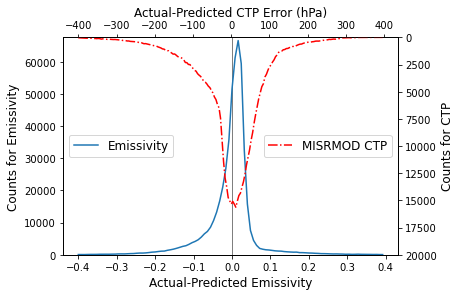

(array([0.016]),
 -8.554835001280013e-05,
 0.07793589928230285,
 array([12.]),
 -0.034505782486577,
 84.55344544544812)

In [26]:
import matplotlib.pyplot as plt
counts1, edges1 = np.histogram(y1-y2, bins=100, range=(-0.4,0.4))
counts2, edges2 = np.histogram(y11-y22, bins=200, range=(-400,400.))
y=np.linspace(-100,np.max(counts1)+1000)
x=np.zeros(len(y))
# plt.hist(Y_test-y_pred2, bins=80, range=(-0.4,0.4), linewidth=1.2, edgecolor='k')
ax=plt.gca()
ax.plot(x,y,'k',linestyle='-',linewidth=0.5)
ax.plot(edges1[:-1],counts1,label="Emissivity")
ax.set_xlabel('Actual-Predicted Emissivity', fontsize=12)
ax.set_ylabel('Counts for Emissivity', fontsize=12)
ax2, ax3 = plt.twinx(), plt.twiny()
ax3.plot(edges2[:-1],counts2,'r',linestyle='-.',label='MISRMOD CTP')
ax3.set_xlabel('Actual-Predicted CTP Error (hPa)', fontsize=12)
ax2.set_ylabel('Counts for CTP', fontsize=12)
ax.set_ylim(0,np.max(counts1)+1000)
ax2.set_ylim(0,20000)
ax2.invert_yaxis()
ax.legend(fontsize=12, loc='center left')
ax3.legend(fontsize=12, loc='center right')
plt.show()
edges1[np.where(counts1==np.max(counts1))], np.mean(y1-y2), np.std(y1-y2), edges2[np.where(counts2==np.max(counts2))], np.mean(y11-y22), np.std(y11-y22)

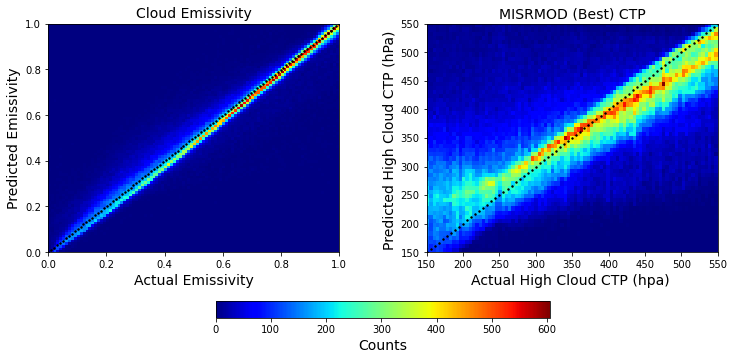

In [27]:
import matplotlib
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax = axes.flat[0]
x=np.linspace(0,1,100)
im1=ax.hist2d(y1,y2,cmap='jet',bins=100)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('auto')
ax.set_xlabel('Actual Emissivity', fontsize=14)
ax.set_ylabel('Predicted Emissivity', fontsize=14)
ax.set_title('Cloud Emissivity', fontsize=14)
ax.scatter(x,x,s=8,color='k',marker='.')
ax = axes.flat[1]
im2=plt.hist2d(y11,y22,cmap='jet',bins=100)
ax.set_xlim(150.,550.)
ax.set_ylim(150.,550.)
ax.set_aspect('auto')
x=np.linspace(0,550,100)
ax.set_xlabel(r'Actual High Cloud CTP (hpa) ', fontsize=14)
ax.set_ylabel(r'Predicted High Cloud CTP (hPa) ', fontsize=14)
ax.set_title('MISRMOD (Best) CTP', fontsize=14)
ax.scatter(x,x,color='k',s=8,marker='.')
fig.subplots_adjust(wspace=0.3)
cb = plt.colorbar(ax=axes.flat[:], orientation='horizontal', shrink=0.5) 
cb.set_label('Counts', fontsize=14)
plt.show()

## Multi-Layer NN (Perceptron) Regression

In [39]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

df = pd.read_csv('C:/Users/arkam/Downloads/Reanalysis/slicing_database_2016_12UTC_2.csv', index_col=0)
# df = df.drop(columns=df.columns[0])
df1 = df.dropna(axis=0,how='any')
# df1 = df1.loc[abs(df1['P']-df1['CTP1'])>50.]

def polyfit(X,Y,deg,var):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 0)
    poly = PolynomialFeatures(degree = deg) 
    X_poly = poly.fit_transform(X_train) 
    X_test_poly = poly.fit_transform(X_test) 
    poly.fit(X_train, Y_train) 
    model2 = linear_model.LinearRegression() 
    model2.fit(X_poly, Y_train)
    y_pred2 = model2.predict(X_test_poly)

    # Root Mean Squared Deviation and R^2 value
    rmsd = np.sqrt(mean_squared_error(Y_test, y_pred2))      
    r2_value = r2_score(Y_test, y_pred2)  

    print("Regression Model for ",var)
    print("Root Mean Square Error \n", rmsd)
    print("R^2 Value: \n", r2_value)
    
    return Y_test,y_pred2,poly.powers_,model2.coef_

X = df1.drop(columns=['P','em'])
Y = df1['em'] 
y1,y2,p1,c1 = polyfit(X,Y,2,'Amount')

amount = np.zeros(df1.shape[0])
for j in range(df1.shape[0]):
    for i in range(p1.shape[0]):
        amount[j] = amount[j] + (df1['P_low'].values[j]**p1[i,0]*df1['CTP'].values[j]**p1[i,1]*df1['am'].values[j]**p1[i,2])*c1[i]
df1['amount']=amount
df1 = df1.drop(df1[(df1.amount <= 0.)].index)
df1 = df1.drop(df1[(df1.amount > 1.)].index)

df1

Regression Model for  Amount
Root Mean Square Error 
 0.07793594623446486
R^2 Value: 
 0.9139044138858747


,P,em,P_low,CTP,am,amount
0,302.564813,0.520532,470.054699,165.0,0.524560,0.439620
1,302.564813,0.520532,786.601827,175.0,0.548030,0.454652
2,302.564813,0.520532,892.453441,175.0,0.566847,0.453288
3,302.564813,0.520532,513.297001,170.0,0.524485,0.441673
4,302.564813,0.520532,498.980385,165.0,0.526410,0.444416
...,...,...,...,...,...,...
3311155,334.351999,0.825762,589.726098,210.0,0.537258,0.439314
3311156,334.351999,0.825762,643.178906,210.0,0.537992,0.440181
3311157,334.351999,0.825762,441.317365,210.0,0.502706,0.396299
3311158,334.351999,0.825762,493.786909,210.0,0.523350,0.420991


In [44]:
X = df1.drop(columns=['P','em']); 
Y = df1['P']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state= 0)
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal', activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal', activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adagrad', metrics=['mean_absolute_error'])
NN_model.summary()

checkpoint_name = 'C:/Users/arkam/Downloads/Reanalysis/ctp_dataWeights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

#Originally run with 10 epochs
NN_model.fit(X_train, Y_train, epochs = 10, batch_size=64, validation_split = 0.2, callbacks = callbacks_list)
NN_model.save('C:/Users/arkam/Downloads/Reanalysis/CTP_NN_model2.h5')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_27 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_28 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_29 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 257       
Total params: 165,505
Trainable params: 165,505
Non-trainable params: 0
_________________________________________________________________
Train on 1600115 samples, validate on 400029 samples
Epoch 1/10
1600115/1600115 [==============================] -

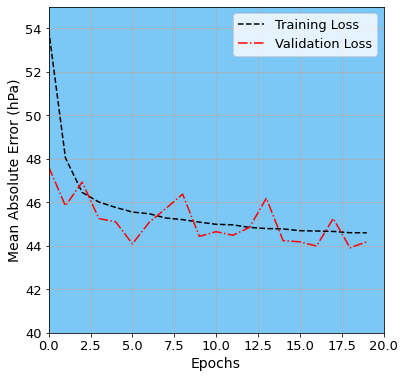

In [13]:
training_loss = [53.9203,48.0439,46.4565,46.0133,45.7663,45.5533,45.4759,45.2794,45.2049,45.0901,44.9897,44.9649,44.8469,44.7941,44.7778,
                44.6957,44.6817,44.6615,44.6034,44.5981]
validation_loss = [47.6283,45.8399,46.9320,45.2521,45.1058,44.0897,45.0772,45.7191,46.3759,44.4365,44.6513,44.4855,44.8493,46.1935,44.2394,
                  44.1837,43.9913,45.2578,43.9093,44.1861]
epochs = np.arange(0,20)

plt.figure(figsize=(6,6))
plt.plot(epochs, training_loss, color='k', linestyle='--', label='Training Loss')
plt.plot(epochs, validation_loss, color='r', linestyle='-.', label='Validation Loss')
plt.xlabel('Epochs', fontsize=14)
plt.gca().set_facecolor('xkcd:lightblue')
plt.ylim(40.,55.)
plt.xlim(0,20)
plt.ylabel('Mean Absolute Error (hPa)', fontsize=14)
plt.legend(fontsize=13)
plt.grid('on')

for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(13)
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(13)

plt.show()

In [31]:
# Load weights of the best model :
weights_file = 'C:/Users/arkam/Downloads/Reanalysis/ctp_dataWeights-007--43.92612.hdf5' # choose the best checkpoint 
NN_model.load_weights(weights_file)
print('Loaded model weights from hdf4 file....')
#Generate Model Predictions for a month of data:
y22 = NN_model.predict(X_test)
y11 = Y_test

Loaded model weights from hdf4 file....


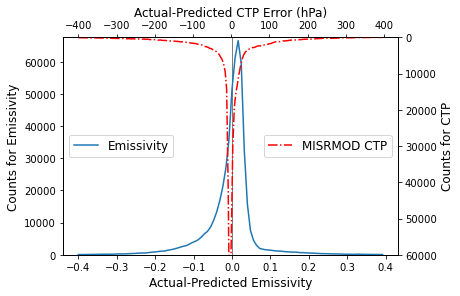

In [40]:
import matplotlib.pyplot as plt
counts1, edges1 = np.histogram(y1-y2, bins=100, range=(-0.4,0.4))
counts2, edges2 = np.histogram(y11-y22.ravel(), bins=200, range=(-400,400.))
y=np.linspace(-100,np.max(counts1)+1000)
x=np.zeros(len(y))
# plt.hist(Y_test-y_pred2, bins=80, range=(-0.4,0.4), linewidth=1.2, edgecolor='k')
ax=plt.gca()
ax.plot(x,y,'k',linestyle='-',linewidth=0.5)
ax.plot(edges1[:-1],counts1,label="Emissivity")
ax.set_xlabel('Actual-Predicted Emissivity', fontsize=12)
ax.set_ylabel('Counts for Emissivity', fontsize=12)
ax2, ax3 = plt.twinx(), plt.twiny()
ax3.plot(edges2[:-1],counts2,'r',linestyle='-.',label='MISRMOD CTP')
ax3.set_xlabel('Actual-Predicted CTP Error (hPa)', fontsize=12)
ax2.set_ylabel('Counts for CTP', fontsize=12)
ax.set_ylim(0,np.max(counts1)+1000)
ax2.set_ylim(0,60000)
ax2.invert_yaxis()
ax.legend(fontsize=12, loc='center left')
ax3.legend(fontsize=12, loc='center right')
plt.show()
# edges1[np.where(counts1==np.max(counts1))], np.mean(y1-y2), np.std(y1-y2), edges2[np.where(counts2==np.max(counts2))], np.mean(y11-y22), np.std(y11-y22)

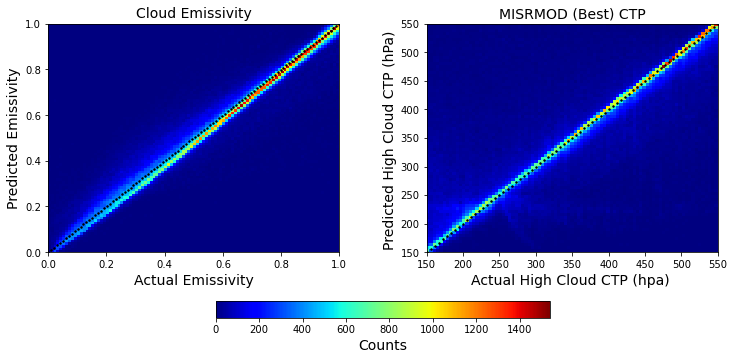

In [33]:
import matplotlib
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax = axes.flat[0]
x=np.linspace(0,1,100)
im1=ax.hist2d(y1,y2,cmap='jet',bins=100)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_aspect('auto')
ax.set_xlabel('Actual Emissivity', fontsize=14)
ax.set_ylabel('Predicted Emissivity', fontsize=14)
ax.set_title('Cloud Emissivity', fontsize=14)
ax.scatter(x,x,s=8,color='k',marker='.')
ax = axes.flat[1]
im2=plt.hist2d(y11,y22.ravel(),cmap='jet',bins=100)
ax.set_xlim(150.,550.)
ax.set_ylim(150.,550.)
ax.set_aspect('auto')
x=np.linspace(0,550,100)
ax.set_xlabel(r'Actual High Cloud CTP (hpa) ', fontsize=14)
ax.set_ylabel(r'Predicted High Cloud CTP (hPa) ', fontsize=14)
ax.set_title('MISRMOD (Best) CTP', fontsize=14)
ax.scatter(x,x,color='k',s=8,marker='.')
fig.subplots_adjust(wspace=0.3)
cb = plt.colorbar(ax=axes.flat[:], orientation='horizontal', shrink=0.5) 
cb.set_label('Counts', fontsize=14)
plt.show()

In [45]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.metrics import mean_squared_error, r2_score

df1 = pd.read_csv('C:/Users/arkam/Downloads/Reanalysis/TopLayer_2015_reduced.csv')
df2 = pd.read_csv('C:/Users/arkam/Downloads/Reanalysis/TopLayer_2016_reduced.csv')
df = pd.concat([df1,df2])
# df = df.drop(np.where(df['cats'].values<0.)[0][:]); df.reset_index(drop=True, inplace=True)
# df = df.drop(np.where(df['misr'].values<0.)[0][:]); df.reset_index(drop=True, inplace=True)
# df = df.drop(np.where(df['modis'].values<0.)[0][:]); df.reset_index(drop=True, inplace=True)
X_inp = df.drop(columns=['catsp'])
y11 = df['catsp']
# Load weights of the best model :
from keras.models import load_model
weights_file = 'C:/Users/arkam/Downloads/Reanalysis/CTP_NN_model2.h5'
model = load_model(weights_file)
print('Loaded model weights from hdf4 file....')
# y11 = y11.iloc[np.ravel(np.where(X_inp['misrp'].values-X_inp['modisp'].values>100.))]
# X_inp = X_inp.iloc[np.ravel(np.where(X_inp['misrp'].values-X_inp['modisp'].values>100.))]
y22 = model.predict(X_inp)#; y11 = df['catsp']
y22.ravel()

Loaded model weights from hdf4 file....


array([449.91882, 253.9871 , 272.2448 , ..., 427.74106, 267.4527 ,
       295.3728 ], dtype=float32)

[67.94055202] [101.91082803]
[0.]
[-80.]


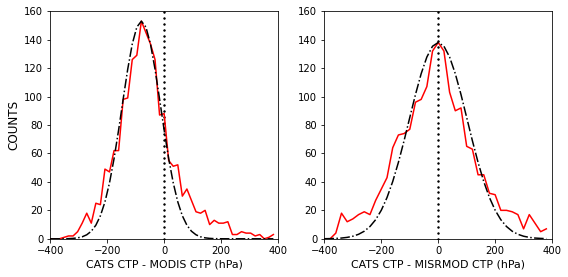

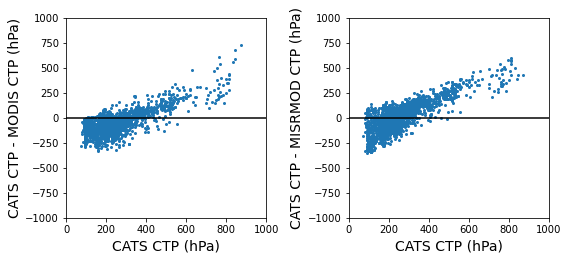

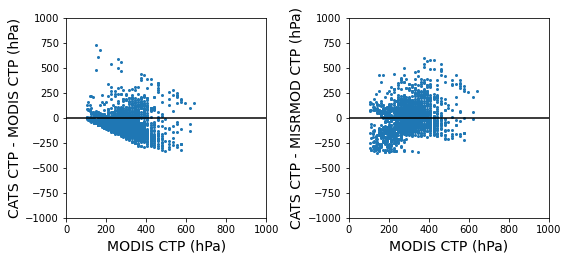

In [48]:
def FWHM(X,Y):
    half_max = max(Y) / 2.
    #find when function crosses line half_max (when sign of diff flips)
    #take the 'derivative' of signum(half_max - Y[])
    d = np.sign(half_max - np.array(Y[0:-1])) - np.sign(half_max - np.array(Y[1:]))
    #plot(X[0:len(d)],d) #if you are interested
    #find the left and right most indexes
    left_idx = np.where(d > 0)[0]
    right_idx = np.where(d < 0)[-1]
    return (X[right_idx] - X[left_idx])/2.355, X[np.where(Y==max(Y))], max(Y) #return the difference (full width)

def gaussian(x,a,mu,sig):
    return a * np.exp(-(x-mu)**2.0/(2*sig**2))

counts, edges = np.histogram(df['catsp'].values-df['modisp'].values, range=(-400.,400.), bins=50)
counts1, edges1 = np.histogram(y11.values-y22.ravel()+100., range=(-400.,400.), bins=40)
f1, m1, a1 = FWHM(edges[:-1],counts); f2, m2, a2 = FWHM(edges1[:-1],counts1)
print(f1,f2)
y = np.linspace(0.,200.)
x = np.zeros(len(y))
print(edges1[np.where(counts1==np.max(counts1))]); print(edges[np.where(counts==np.max(counts))])
fig=plt.figure(figsize=(8,8))
plt.subplot(121, aspect=5);plt.plot(edges[:-1], counts, color='r');plt.xlim(-400,400);plt.ylim(0,160);plt.scatter(x,y,color='k',s=2)
plt.plot(edges[:-1], gaussian(edges[:-1],a1, m1, f1), color='k', linestyle='-.')
plt.ylabel('COUNTS', fontsize=12);plt.xlabel('CATS CTP - MODIS CTP (hPa)', fontsize=11)
plt.subplot(122, aspect=5);plt.plot(edges1[:-1], counts1, color='r');plt.xlim(-400,400);plt.ylim(0,160);plt.scatter(x,y,color='k',s=2)
plt.plot(edges1[:-1], gaussian(edges1[:-1], a2, m2, f2), color='k', linestyle='-.')
plt.xlabel('CATS CTP - MISRMOD CTP (hPa)', fontsize=11);fig.tight_layout();plt.show()
x = np.linspace(0.,1000.)
y = np.zeros(len(x))
fig=plt.figure(figsize=(8,8))
plt.subplot(121, aspect=0.5);plt.scatter(df['catsp'].values,df['catsp'].values-df['modisp'].values,s=4)
plt.plot(x,y,'k')
plt.xlim(0.,1000.)
plt.ylim(-1000.,1000.)
plt.ylabel('CATS CTP - MODIS CTP (hPa)', fontsize=14)
plt.xlabel('CATS CTP (hPa)', fontsize=14)
plt.subplot(122, aspect=0.5);plt.scatter(y11.values,df['catsp'].values-y22.ravel()+100.,s=4)
plt.plot(x,y,'k')
plt.xlim(0.,1000.)
plt.ylim(-1000.,1000.)
plt.ylabel('CATS CTP - MISRMOD CTP (hPa)', fontsize=14)
plt.xlabel('CATS CTP (hPa)', fontsize=14)
fig.tight_layout()
plt.show()
fig=plt.figure(figsize=(8,8))
plt.subplot(121, aspect=0.5);plt.scatter(df['modisp'].values,df['catsp'].values-df['modisp'].values,s=4)
plt.plot(x,y,'k')
plt.xlim(0.,1000.)
plt.ylim(-1000.,1000.)
plt.ylabel('CATS CTP - MODIS CTP (hPa)', fontsize=14)
plt.xlabel('MODIS CTP (hPa)', fontsize=14)
plt.subplot(122, aspect=0.5);plt.scatter(df['modisp'].values,df['catsp'].values-y22.ravel()+100.,s=4)
plt.plot(x,y,'k')
plt.xlim(0.,1000.)
plt.ylim(-1000.,1000.)
plt.ylabel('CATS CTP - MISRMOD CTP (hPa)', fontsize=14)
plt.xlabel('MODIS CTP (hPa)', fontsize=14)
fig.tight_layout()
plt.show()

In [28]:
y11 = y11.iloc[np.ravel(np.where(X_inp['misrp'].values-X_inp['modisp'].values>100.))]
X2 = X_inp.iloc[np.ravel(np.where(X_inp['misrp'].values-X_inp['modisp'].values>100.))]
X2

,misrp,modisp,emis,amount
0,762.083619,275.0,0.26,0.360678
1,430.117027,285.0,0.35,0.301143
2,405.552323,300.0,0.32,0.254950
4,422.056948,245.0,0.44,0.402556
5,686.369731,515.0,0.73,0.667757
...,...,...,...,...
1263,483.716392,345.0,0.52,0.452763
1264,522.001345,390.0,0.40,0.327906
1265,539.936871,425.0,0.52,0.436077
1267,605.000561,300.0,0.40,0.407976


In [26]:
y11.iloc[np.ravel(np.where(X_inp['misrp'].values-X_inp['modisp'].values>100.)[0])]

0       343.808033
1       282.317643
2       349.773959
4       266.715706
5       408.663247
           ...    
1263    194.345900
1264    198.186750
1265    192.127744
1267    203.542183
1268    210.984845
Name: catsp, Length: 1565, dtype: float64

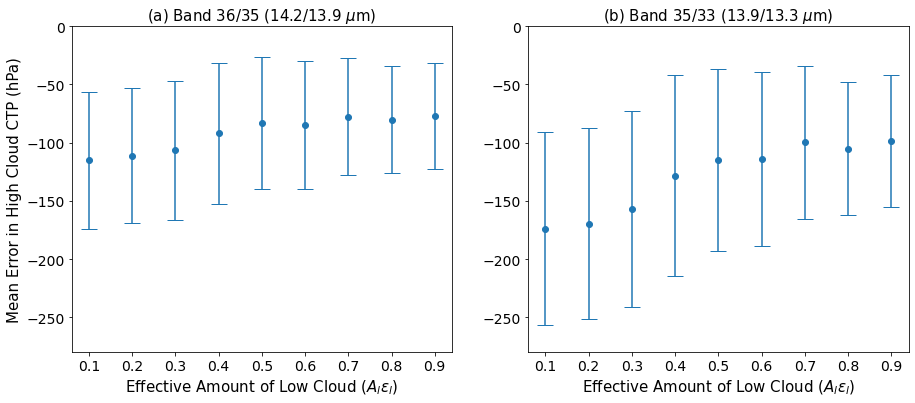

In [6]:
import glob
import numpy as np
import xarray as xr

mean_err = np.zeros(9); std_err = np.zeros(9)
ermat = sorted(glob.glob('*withOD.nc')); error = np.zeros((5,9,10,6,5,8,2,2))
for i in range(len(ermat)):
    error[i,:,:,:,:,:,:,:] = xr.open_dataset(ermat[i]).__xarray_dataarray_variable__.data
    
import matplotlib.pyplot as plt
for i in range(1,10):
    mean_err[i-1] = np.nanmean(error[:,i-1,2,0,:,:,:,0])
    std_err[i-1] = np.nanmean(error[:,i-1,2,0,:,:,:,1])
fig = plt.figure(figsize=(15,6));fig.set_facecolor('w')
plt.subplot(1,2,1);plt.scatter(np.arange(1,10)/10., mean_err); plt.ylim(-280,0)
plt.errorbar(np.arange(1,10)/10., mean_err, yerr = std_err, zorder=0, fmt ='none', capsize=8)
plt.xlabel('Effective Amount of Low Cloud ($A_l \epsilon_l$)', fontsize=15); 
plt.title('(a) Band 36/35 (14.2/13.9 $\mu$m)', fontsize=15)
plt.ylabel('Mean Error in High Cloud CTP (hPa)', fontsize=15);
for l in plt.gca().yaxis.get_ticklabels():
    l.set_fontsize(14)
for l in plt.gca().xaxis.get_ticklabels():
    l.set_fontsize(14)
for i in range(1,10):
    mean_err[i-1] = np.nanmean(error[:,i-1,2,0,:,:,1,0])
    std_err[i-1] = np.nanmean(error[:,i-1,2,0,:,:,1,1])
plt.subplot(1,2,2);plt.scatter(np.arange(1,10)/10., mean_err); plt.ylim(-280,0); 
plt.title('(b) Band 35/33 (13.9/13.3 $\mu$m)', fontsize=15)
plt.errorbar(np.arange(1,10)/10., mean_err, yerr = std_err, zorder=0, fmt ='none', capsize=8);
for l in plt.gca().yaxis.get_ticklabels():
    l.set_fontsize(14)
for l in plt.gca().xaxis.get_ticklabels():
    l.set_fontsize(14)
plt.xlabel('Effective Amount of Low Cloud ($A_l \epsilon_l$)', fontsize=15)
# plt.suptitle('High Cloud CTP = 350 hPa, Low Cloud CTP = 800 hPa', fontsize=14)

plt.savefig('C:/Users/arkam/Box/Prelim/Manuscript2/Plots/errors_with_lowcloudOD.png', dpi=450); 
plt.show()

In [ ]:
[142, 138, 136, 135, 130, 132, 128, 128, 128]

In [3]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

ermat = sorted(glob.glob('ErrorMatrices/*x5.nc'))
highctpgrid = np.arange(100, 600, 50); lowctpgrid = np.arange(700, 1000, 50)
depthgrid = np.arange(25, 150, 25); odgrid = np.arange(.25,2.25,.25)
error = np.zeros((5,10,6,5,8,2,2))
pressure = modis.transmission.pstd; std_grid = []

for i in range(len(ermat)):
    error[i,:,:,:,:,:,:] = xr.open_dataset(ermat[i]).__xarray_dataarray_variable__.data

def find_indices(highctp, lowctp, depth, od):
    
    try:
        highctp_index = np.where(np.abs(highctpgrid - highctp) == 
                          np.abs(highctpgrid - highctp).min())[0][0]
    except:
        highctp_index = len(highctpgrid)-1
    try:
        lowctp_index = np.where(np.abs(lowctpgrid - lowctp) == 
                          np.abs(lowctpgrid - lowctp).min())[0][0]
    except:
        lowctp_index = len(lowctpgrid)-1
    try:
        depth_index = np.where(np.abs(depthgrid - depth) == 
                          np.abs(depthpgrid - depth).min())[0][0]
    except:
        depth_index = len(depthgrid)-1
    try:
        od_index = np.where(np.abs(odgrid - od) == 
                          np.abs(odgrid - od).min())[0][0]
    except:
        od_index = len(odgrid)-1
        
    return highctp_index, lowctp_index, depth_index, od_index

A = np.loadtxt('sample_output_2017_multi2.txt');best=[];misr=[];cats=[];modis=[]; corr=[]; band = 0; bias=[]; std=[]
A = A[np.where(A[:,3]<1000.)]; A = A[np.where(A[:,4]<450.)];  ind = np.where(A[:,0]<=0.); A[ind, 0] = A[ind,1]
# A = A[np.where(A[:,5]-A[:,4]>150.)]
# A = A[np.where(A[:,5]>680.)]
for i in range(np.shape(A)[0]):
    if A[i,0]<450 and A[i,0]!=0. and A[i,0]<A[i,2]:
        best=np.append(best,A[i,0])
        misr=np.append(misr,A[i,5])
        cats=np.append(cats,A[i,4])
        modis=np.append(modis,A[i,2])
        curr_best=A[i,0]
    
    elif A[i,1]<650 and A[i,1]!=0. and A[i,1]<A[i,2]:
        best=np.append(best,A[i,1])
        misr=np.append(misr,A[i,5])
        cats=np.append(cats,A[i,4])
        modis=np.append(modis,A[i,2])
        curr_best=A[i,1]; band = 1

    else:
        best=np.append(best,A[i,2])
        misr=np.append(misr,A[i,5])
        cats=np.append(cats,A[i,4])
        modis=np.append(modis,A[i,2])
        curr_best=A[i,2]
    
    if A[i,6]<450 and A[i,6]!=0. and A[i,6]<curr_best:
        corr=np.append(corr,A[i,6])
    elif A[i,7]<650 and A[i,7]!=0. and A[i,7]<curr_best:
        corr=np.append(corr,A[i,7]); band = 1
    else:
        corr=np.append(corr,curr_best)
    if corr[len(corr)-1] < 120:
        corr[len(corr)-1]=curr_best
    std_level_index = np.where(np.abs(pressure - curr_best) == 
                        np.abs(pressure - curr_best).min())[0][0]
    std_level = (pressure[std_level_index+1]-pressure[std_level_index-1])/2
    
    highctp_index, lowctp_index, depth_index, od_index = find_indices(A[i,4], A[i,5], A[i,8]-A[i,4], A[i,9]/2.135)
    bias.append(error[int(A[i,10]), highctp_index, lowctp_index, depth_index, od_index, band, 0])
    std.append(error[int(A[i,10]), highctp_index, lowctp_index, depth_index, od_index, band, 1])
    std_grid.append(std_level)
    
std_coll=(900**2*corr**2)/(8500**2)
print(sum(np.abs((corr-bias-cats-60)/np.sqrt(np.array(std)**2+np.array(std_grid)**2+std_coll))<1.96)/float(np.size(corr)))
plt.hist((corr-bias-cats-60)/np.sqrt(np.array(std)**2+np.array(std_grid)**2+np.array(std_coll)), bins=50); plt.xlim(-10,10);
plt.axvline(x = -1.96,linestyle='--',color='r'); plt.xlabel('Theoretical errors (in units of $\sigma$)', fontsize=14)
plt.ylabel('COUNTS', fontsize=14); plt.axvline(x = 1.96, linestyle='--',color='r'); plt.show()

NameError: name 'modis' is not defined